Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Day 1:  Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [✓] Choose your target. Which column in your tabular dataset will you predict?
        A: target = 'is_churn'

- [✓] Is your problem regression or classification?
        A:  Binary classification + also focus on predicted probabilities (predict_proba, non-binary)

- [✓] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?


            A:  Highly imbalanced: 94% did not churn ('is_churn' == 0), while 6% did churn in Feb. 2017.  This makes sense considering 6% of your total subscribers churning every month is not low -- if it was e.g., 50%, the business would collapse in 1-2 months.  Will take a look at class_balance params, but given there are still many more 'is_churn'=1 observations than I need, I most likely will not try to change this balance when sampling.  Instead, I will focus on different metrics -- recall ("hit rate"), false negative rate (FNR or "miss rate") and log loss -- when setting up my predictive model(s).
    
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [✓] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
        

            A:  A time-based split.  I am using the separate March 2017 datasets as the test sets, and not touching them during the predictive modeling process, in order to avoid any leakage.
        

- [✓] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency > 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?

            A:  94% of the observations in the training set are in my majority class and did not churn in Feb. 2017 ('is_churn' == 0), while 6% did churn in Feb. 2017.  As such, accuracy is unlikely to be useful -- a dummy majority classifier baseline is already 94% accurate, BUT has 0.0 recall.  With this problem, our priority is to predict what probability each user has of churning "next" month and identify those users we predict will churn, so our customer retention and/or sales team(s) can try to better engage those users.  So it is most important to successfully predict all/most of the users who will churn (high recall), and false positives are actually not too problematic (we can accept lower precision if doing so will increase our recall).  As such, the metrics I will use for evaluating my models are:
        (1) recall ("hit rate"), 
        (2) false negative rate (FNR or "miss rate"), and 
        (3) log loss -- when setting up my predictive model(s).


- [✓] Begin to clean and explore your data.


- [✓] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Day 2:  Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [✓] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [✓] Fit a model. Does it beat your baseline? 
- [✓] Try xgboost.
- [✓] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.

# **Setup + Import Dataset:**

In [3]:
# Import libraries used:
import pandas as pd
import numpy as np

import re
import datetime as dt
from scipy.stats import randint as sp_randint, uniform as sp_uniform  # randint = uniform discrete random variable, uniform = uniform continuous random variable

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, log_loss

In [4]:
!pwd

/Users/huskeycl/LSDS_Unit_2/U2-S4_build_project_2_kkbox_churn


In [5]:
!ls

LS DS - U2-S4 Project - KKBox Subscriber Churn.ipynb
Scratch Notebook -- To Remove.ipynb
WSDMChurnLabeller.scala
kaggle_kkbox_source_files.zip
members_v3.csv
members_v3.csv.7z
pre_prepped_data_for_code_reviewers
sample_submission_v2.csv
sample_submission_v2.csv.7z
sample_submission_zero.csv
sample_submission_zero.csv.7z
train.csv
train.csv.7z
train_v2.csv
train_v2.csv.7z
transactions.csv
transactions.csv.7z
transactions_v2.csv
transactions_v2.csv.7z
user_logs.csv
user_logs.csv.7z
user_logs_v2.csv
user_logs_v2.csv.7z


In [6]:
# !unzip kaggle_kkbox_source_files.zip

In [7]:
# [?? To do:  Unzip .7z files to get .csv files ??]

In [8]:
# Make working_data (training + val) and test dataframes:
working_data = pd.read_csv('train.csv')
test_all = pd.read_csv('train_v2.csv')

# Make other dataframes (to merge with train and test):
members_all = pd.read_csv('members_v3.csv')
transactions_all = pd.read_csv('transactions.csv')
transactions_all_test = pd.read_csv('transactions_v2.csv')

# Combine all transactions into one dataframe (since we will need to filter by date later anyway to prevent leakage):
transactions_all = pd.concat([transactions_all, transactions_all_test])

In [9]:
# WARNING!:  These are 30.5 GB and 1.4 GB files -- run this cell only when 
# necessary!
%time user_logs_all = pd.read_csv('user_logs.csv')
%time user_logs_all_test = pd.read_csv('user_logs_v2.csv')

# Combine all user_logs into one dataframe (since we will need to filter by date later anyway to prevent leakage):
%time user_logs_all = pd.concat([user_logs_all, user_logs_all_test])

CPU times: user 4min 51s, sys: 4min 18s, total: 9min 9s
Wall time: 12min 8s
CPU times: user 19.3 s, sys: 9.56 s, total: 28.8 s
Wall time: 30.5 s
CPU times: user 24.8 s, sys: 1min 51s, total: 2min 15s
Wall time: 3min 26s


In [10]:
# Reset indices to remove duplicate numbers:
transactions_all.reset_index(inplace=True, drop=True)
user_logs_all.reset_index(inplace=True, drop=True)

In [11]:
# Drop unused information from massive user_logs dataframe (410 mn observations!!):
# We currently are not using any listening data from before July 2016, so we can remove all 
# 2015/01-2016/06 observations for now:
user_logs_all = user_logs_all[user_logs_all['date'] >= 20160701]

In [12]:
# First-level data cleaning: Eliminate completely implausible values, etc.:

# Data cleaning for members dataframe:
members_all['bd'] = members_all['bd'].mask(members_all['bd'] < 10.0, np.NaN)
members_all['bd'] = members_all['bd'].mask(members_all['bd'] > 100.0, np.NaN)
members_all['registered_via'] = members_all['registered_via'].replace({-1: np.NaN})

# Data cleaning for transactions df:
transactions_all['membership_expire_date'] = transactions_all['membership_expire_date'].mask(transactions_all['membership_expire_date'] < transactions_all['membership_expire_date'].quantile(0.0001), np.NaN)
transactions_all['membership_expire_date'] = transactions_all['membership_expire_date'].mask(transactions_all['membership_expire_date'] > transactions_all['membership_expire_date'].quantile(0.9999), np.NaN)

# Data cleaning for user_logs df:
user_logs_all = user_logs_all[(user_logs_all['total_secs'] < user_logs_all['total_secs'].quantile(0.9995))
                             & (user_logs_all['num_25'] < user_logs_all['num_25'].quantile(0.9995))
                             & (user_logs_all['num_50'] < user_logs_all['num_50'].quantile(0.9995))
                             & (user_logs_all['num_75'] < user_logs_all['num_75'].quantile(0.9995))
                             & (user_logs_all['num_985'] < user_logs_all['num_985'].quantile(0.9995))
                             & (user_logs_all['num_100'] < user_logs_all['num_100'].quantile(0.9995))
                             ]


In [13]:
# Split working_data into train and val sets:
train_all, val_all = train_test_split(working_data, 
                                      train_size=0.75, 
                                      shuffle=True, 
                                      stratify=working_data['is_churn'], 
                                      random_state=42
                                     )

In [14]:
working_data.shape

(992931, 2)

In [15]:
train_all.shape, val_all.shape, test_all.shape

((744698, 2), (248233, 2), (970960, 2))

In [16]:
members_all.shape, transactions_all.shape, user_logs_all.shape

((6769473, 6), (22978755, 9), (155149646, 9))

# !!! DON'T RERUN ABOVE THIS !!!  
(takes 10 years to run...)

### Subsets:  Take random sample to get subset of data (otherwise too large a dataset to work with efficiently):

In [109]:
# [?? To do: Add a learning curve chart to decide how much of train and val to use, and show why ??]

In [110]:
# Subsets:  Take IID random subsamples of train, val, test that are small enough to work with.
# train_all, val_all, test_all are all to big to work with.

num_to_sample = 25000

# Straight samples mirroring original target variable distribution (keep class imbalance):
train_imbalanced = train_all.sample(n=num_to_sample, replace=True, random_state=42)
train_imbalanced.reset_index(inplace=True, drop=True)

val = val_all.sample(n=num_to_sample, replace=True, random_state=42)
val.reset_index(inplace=True, drop=True)

test = test_all.sample(num_to_sample, replace=True, random_state=42)
test.reset_index(inplace=True, drop=True)

In [111]:
# Balanced classes samples from under-sampling the majority class (best approach given we 
# have many more data points than we can use):

from sklearn.utils import shuffle, resample

target = 'is_churn'

ratio = 1/2
balanced_num = int(num_to_sample * ratio)

# train (balanced classes):

not_churn_sample_train = train_all[train_all[target] == 0].sample(n=balanced_num + 1, 
                                                                  replace=True, 
                                                                  random_state=42)
yes_churn_sample_train = train_all[train_all[target] == 1].sample(n=balanced_num, 
                                                                  replace=True, 
                                                                  random_state=42)

train = pd.concat([not_churn_sample_train, yes_churn_sample_train])
train = shuffle(train, random_state=42)
train.reset_index(inplace=True, drop=True)

# val_balanced version, just in case we want to use it later for cross-validation:

not_churn_sample_val = val_all[val_all[target] == 0].sample(n=balanced_num, 
                                                            replace=True, 
                                                            random_state=42)
yes_churn_sample_val = val_all[val_all[target] == 1].sample(n=balanced_num, 
                                                            replace=True, 
                                                            random_state=42)

val_balanced = pd.concat([not_churn_sample_val, yes_churn_sample_val])
val_balanced = shuffle(val_balanced, random_state=42)
val_balanced.reset_index(inplace=True, drop=True)

In [112]:
# Make a list of all msno IDs in the new subsets train, val and test, for our data_prep function:
all_subsets_msnos = list(train['msno']) + list(val['msno']) + list(test['msno']) # + list(val_balanced['msno']) + list(train_imbalanced['msno'])

In [113]:
# Take subsets of members, transactions, user_logs for only those users included in the above subsets 
# (otherwise compute time is unfeasibly long, e.g., for all 24.6 mn rows in user_logs):
members = members_all[members_all['msno'].isin(all_subsets_msnos)]
transactions = transactions_all[transactions_all['msno'].isin(all_subsets_msnos)]
user_logs = user_logs_all[user_logs_all['msno'].isin(all_subsets_msnos)]

In [114]:
train.shape, val.shape, test.shape

((25000, 2), (25000, 2), (25000, 2))

In [115]:
members.shape, transactions.shape, user_logs.shape

((63074, 6), (1148734, 9), (7710158, 9))

In [116]:
train.head()

msno  is_churn
16552   G8FefH0MNOuCUk6AqdLVWiyPCTaN/bZGeXJyShO7+ac=         1
682774  p88PKOPAekKAMRcfJFLqypW+29oypZgu7OhM+OMhe7Y=         0
856356  fPxGxUHllzIDKkUCapeNtdvxe1KeiRE/+f5ZIIVXxDM=         0
683025  Tywb25GQ2u75kZ9YymYHp1bMWveZBTjfjnoDpmxt3Ew=         0
60765   rffmmuTprm+iFppWr9XILBFp4wUjaRPXrYmj8ShugIE=         1

In [117]:
members.head()

msno  city    bd  gender  \
37   den0Kb2s4BV47zV+tSC1u0W07M7BOMq+fnrGj+9ax0I=    14  26.0  female   
71   Jul8xeVqsOHp2dFxcL3kN6jyLN8Xv36jDlctKTOrnHs=     1   NaN     NaN   
94   bPHi7VPQkMtdeIqJAktzYSITpRSt9F9mCdhddPTSlOY=    15  17.0  female   
232  fkLgfIOX0bWM9/BQQChOCDzoos23szsckxPvxrBbtmY=     4  20.0  female   
309  0uAjNEzX6IY+lZ+PYv9W31mZjHxUWkbFz9LL8m9G46k=    15  23.0  female   

     registered_via  registration_init_time  
37              9.0                20111005  
71              7.0                20111022  
94              3.0                20141021  
232             9.0                20141029  
309             7.0                20141103

In [118]:
transactions.head()

msno  payment_method_id  \
1   AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=                 41   
4   yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=                 39   
19  Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=                 39   
21  T4XSZA0yn0xAe3pjL4PwR4Oi9KooBibT+S/3xmzEZLw=                 39   
47  pXpFcJbT8/FDkhnSUzNV3X2WTzUg5I4poa0+aJdIm/0=                 34   

    payment_plan_days  plan_list_price  actual_amount_paid  is_auto_renew  \
1                  30              149                 149              1   
4                  30              149                 149              1   
19                 30              149                 149              1   
21                 30              149                 149              1   
47                 30              149                 149              1   

    transaction_date  membership_expire_date  is_cancel  
1           20150930              20151031.0          0  
4           20150930              20151121.0          0  
19          20150930              20151108.0          0  
21          20150930              20151119.0          0  
47          20151130              20151231.0          0

In [119]:
user_logs.head()

msno      date  num_25  num_50  \
117  9IzdFLkXN+UUsGLLC3C5cEaChLBk/NhJWIwM+CvsMbE=  20160713       4       0   
118  9IzdFLkXN+UUsGLLC3C5cEaChLBk/NhJWIwM+CvsMbE=  20160916       1       0   
119  9IzdFLkXN+UUsGLLC3C5cEaChLBk/NhJWIwM+CvsMbE=  20161130       1       0   
120  9IzdFLkXN+UUsGLLC3C5cEaChLBk/NhJWIwM+CvsMbE=  20170220       3       1   
238  rE5wSmHEF1Dhu55zhkiGB1HvotdlSHcIMGXv6VcqO2A=  20160718       5       1   

     num_75  num_985  num_100  num_unq  total_secs  
117       1        0        4        8    1202.130  
118       0        0        1        2     374.743  
119       0        0        6        6    2483.134  
120       0        1        6        9    2040.429  
238       2        4        5       12    2767.641

# **Data Prep. & Feature Engineering:**

In [120]:
# Set the correct cutoff date for the dataset = first day of the renewal period (to prevent data leakage):
cutoff_train = dt.datetime(2017, 2, 1)
cutoff_test = dt.datetime(2017, 3, 1)

In [121]:
# Data prep. for members, transactions, user_logs:

# Members:
members.loc[:, 'registration_init_time'] = pd.to_datetime(members['registration_init_time'], format='%Y%m%d')
members.rename(columns={'bd': 'age'}, inplace=True)

# Transactions:
# [?? To do... ??]
transactions.loc[:, 'transaction_date'] = pd.to_datetime(transactions['transaction_date'], format='%Y%m%d')
transactions.loc[:, 'membership_expire_date'] = pd.to_datetime(transactions['membership_expire_date'], format='%Y%m%d')
transactions.loc[:, 'actual_amount_paid_per_30_days'] = transactions['actual_amount_paid'] / (transactions['payment_plan_days'] / 30)
transactions['actual_amount_paid_per_30_days'].replace({np.inf: np.NaN}, inplace=True)

# User Logs (listening data):
user_logs.loc[:, 'date'] = pd.to_datetime(user_logs['date'], format='%Y%m%d')

In [122]:
# Function that does all data prep on train, val, test:

def data_prep(dataframe, members, transactions, user_logs, cutoff_date):
    # [?? To do: Best to make copies or no ??]
    df = dataframe.copy()
    members = members.copy()
    transactions = transactions[transactions['transaction_date'] < cutoff_date].copy()
    user_logs = user_logs[user_logs['date'] < cutoff_date].copy()
    
#     cutoff_date = cutoff_date
    date_1_month_ago = cutoff_date + pd.DateOffset(months=-1)
    date_6_months_ago = cutoff_date + pd.DateOffset(months=-6)
    
    # Merge key features into main dataframe:
    df = pd.merge(df, members, how='left', on='msno')
    
    # Main dataframe:  OneHot encoding for 0/1 binary features with NaNs:
    columns_for_onehot = ['gender']
    encoder_onehot = ce.OneHotEncoder(use_cat_names=True)
    encoded_columns_onehot = encoder_onehot.fit_transform(df[columns_for_onehot])
    
    encoded_columns_onehot['msno'] = df['msno']                       # Add back msno numbers to merge
    df = pd.merge(df, encoded_columns_onehot, how='left', on='msno')
    
    # NEW FEATURES:
    
    df.loc[:, 'total_days_since_joined'] = (cutoff_date - df['registration_init_time']).dt.days
    
    # More computationally efficient to set these columns as default=NaN, rather than one-by-one as the 
    # elif... part of the below for loop:
    df.loc[:, 'cost_per_month'] = np.NaN
    df.loc[:, 'on_auto_renew'] = np.NaN
    df.loc[:, 'payment_method_latest'] = np.NaN
    df.loc[:, 'churn_returned_in_past'] = np.NaN
    df.loc[:, 'churn_returned_num_times'] = np.NaN
    df.loc[:, 'churned_full_in_past'] = np.NaN
    df.loc[:, 'churned_full_num_times'] = np.NaN
    df.loc[:, 'churned_any_in_past'] = np.NaN
    df.loc[:, 'churned_any_num_times'] = np.NaN

    df.loc[:, 'total_mins_last_month'] = np.NaN
    df.loc[:, 'total_mins_last_6_months'] = np.NaN
    df.loc[:, 'total_mins_last_month'] = np.NaN
    df.loc[:, 'total_mins_last_6_months'] = np.NaN

    df.loc[:, 'num_unique_last_month'] = np.NaN
    df.loc[:, 'num_unique_last_6_months'] = np.NaN
    df.loc[:, 'num_songs_started_last_month'] = np.NaN
    df.loc[:, 'num_songs_started_last_6_months'] = np.NaN
    df.loc[:, 'num_songs_listened_last_month'] = np.NaN
    df.loc[:, 'num_songs_listened_last_6_months'] = np.NaN
    df.loc[:, 'num_songs_finished_last_month'] = np.NaN
    df.loc[:, 'num_songs_finished_last_6_months'] = np.NaN

    df.loc[:, 'songs_affinity_nps_last_month'] = np.NaN
    df.loc[:, 'songs_affinity_nps_last_6_months'] = np.NaN
    df.loc[:, 'songs_percent_loved_last_month'] = np.NaN
    df.loc[:, 'songs_percent_loved_last_6_months'] = np.NaN
    df.loc[:, 'songs_percent_disliked_last_month'] = np.NaN
    df.loc[:, 'songs_percent_disliked_last_6_months'] = np.NaN
    
    df.loc[:, 'avg_active_days_L30_last_month'] = np.NaN
    df.loc[:, 'avg_active_days_L30_last_6_months'] = np.NaN
    df.loc[:, 'is_MAU_last_month'] = np.NaN
    df.loc[:, 'is_WAU_last_month'] = np.NaN
    df.loc[:, 'is_WAU_last_6_months'] = np.NaN
    df.loc[:, 'is_DAU_last_month'] = np.NaN
    df.loc[:, 'is_DAU_last_6_months'] = np.NaN
    
    for row_num in df.index:
        msno = df.loc[row_num, 'msno']

        # ------------------------ TRANSACTIONS/SUBSCRIPTION FEATURES -------------------------------------------
        
        # User's transactions history: pull in useful data from transactions logs:
        transactions_this_user = transactions[transactions['msno'] == msno].sort_values(by='transaction_date', ascending=True)
#         txns_last_month = transactions_this_user[transactions_this_user['transaction_date'] > date_1_month_ago]
#         txns_last_6_months = transactions_this_user[transactions_this_user['transaction_date'] > date_6_months_ago]

        # New features for transactions/subscription history:
        if msno in set(transactions['msno']):
            df.loc[row_num, 'cost_per_month'] = transactions_this_user.iloc[-1]['actual_amount_paid_per_30_days']
            df.loc[row_num, 'on_auto_renew'] = transactions_this_user.iloc[-1]['is_auto_renew']
            df.loc[row_num, 'payment_method_latest'] = transactions_this_user.iloc[-1]['payment_method_id']

            # Make features for 'has churned before' and 'churned before # times':
            cancellations = transactions_this_user[transactions_this_user['is_cancel'] == 1]['transaction_date']
            churn_returned_num_times = 0
            churned_full_num_times = 0
            for cancel_event in cancellations:
                # Check whether: 
                # (a) simply upgraded subscription type (didn't churn); 
                # (b) half-churned or "churn-returned": ended subscription, but reactivated within 30 days; or 
                # (c) full-churned: ended subscription and did not reactivate within 30 days):
                plan_change_range = [cancel_event + pd.DateOffset(days=-1), cancel_event + pd.DateOffset(days=1)]
                plan_change_conditions = (transactions_this_user['transaction_date'] >= plan_change_range[0]) & (transactions_this_user['transaction_date'] <= plan_change_range[1])
                plan_change = (transactions_this_user[plan_change_conditions]['is_cancel'] == 0).sum() >= 1

                renewed_range = [cancel_event + pd.DateOffset(days=-14), cancel_event + pd.DateOffset(days=30)]
                renewed_conditions = (transactions_this_user['transaction_date'] >= renewed_range[0]) & (transactions_this_user['transaction_date'] <= renewed_range[1])
                renewed = (transactions_this_user[renewed_conditions]['is_cancel'] == 0).sum() >= 1

                if renewed == True & plan_change == False:
                    churn_returned_num_times += 1
                elif renewed == False:
                    churned_full_num_times += 1
                # elif renewed == True & plan_change == True:
                    # User simply changed plans (upgraded/downgraded) --> no churn event at all.

            df.loc[row_num, 'churn_returned_in_past'] = churn_returned_num_times >= 1
            df.loc[row_num, 'churn_returned_num_times'] = churn_returned_num_times
            df.loc[row_num, 'churned_full_in_past'] = churned_full_num_times >= 1
            df.loc[row_num, 'churned_full_num_times'] = churned_full_num_times
            df.loc[row_num, 'churned_any_in_past'] = (churn_returned_num_times + churned_full_num_times) >= 1
            df.loc[row_num, 'churned_any_num_times'] = churn_returned_num_times + churned_full_num_times
        
        # ------------------------ LISTENING/USAGE FEATURES -----------------------------------------------------
        
        # User's listening history: pull in useful data for that user from user_logs (listening data):
        listening_logs_this_user = user_logs[user_logs['msno'] == msno].sort_values(by='date', ascending=True)
        logs_last_month = listening_logs_this_user[listening_logs_this_user['date'] > date_1_month_ago]
        logs_last_6_months = listening_logs_this_user[listening_logs_this_user['date'] > date_6_months_ago]

        # New features re the user's listening behavior/history:
        
        # Make INTs for these values --> saves compute time below (vs. df lookup in train, val, test 50+ times for every row):
        num_25_last_month = logs_last_month['num_25'].sum()
        num_50_last_month = logs_last_month['num_50'].sum()
        num_75_last_month = logs_last_month['num_75'].sum()
        num_985_last_month = logs_last_month['num_985'].sum()
        num_100_last_month = logs_last_month['num_100'].sum()

        num_25_last_6_months = logs_last_6_months['num_25'].sum()
        num_50_last_6_months = logs_last_6_months['num_50'].sum()
        num_75_last_6_months = logs_last_6_months['num_75'].sum()
        num_985_last_6_months = logs_last_6_months['num_985'].sum()
        num_100_last_6_months = logs_last_6_months['num_100'].sum()

        num_songs_started_last_month = num_25_last_month + num_50_last_month + num_75_last_month + num_985_last_month + num_100_last_month
        num_songs_started_last_6_months = num_25_last_6_months + num_50_last_6_months + num_75_last_6_months + num_985_last_6_months + num_100_last_6_months

        if df.loc[row_num, 'msno'] in set(user_logs['msno']):
            df.loc[row_num, 'total_mins_last_month'] = logs_last_month['total_secs'].sum() / 60
            df.loc[row_num, 'total_mins_last_6_months'] = logs_last_6_months['total_secs'].sum() / 60
            df.loc[row_num, 'num_unique_last_month'] = logs_last_month['num_unq'].sum()
            df.loc[row_num, 'num_unique_last_6_months'] = logs_last_6_months['num_unq'].sum()
            df.loc[row_num, 'num_songs_started_last_month'] = num_25_last_month + num_50_last_month + num_75_last_month + num_985_last_month + num_100_last_month
            df.loc[row_num, 'num_songs_started_last_6_months'] = num_25_last_6_months + num_50_last_6_months + num_75_last_6_months + num_985_last_6_months + num_100_last_6_months
            df.loc[row_num, 'num_songs_listened_last_month'] = num_75_last_month + num_985_last_month + num_100_last_month
            df.loc[row_num, 'num_songs_listened_last_6_months'] = num_75_last_6_months + num_985_last_6_months + num_100_last_6_months
            df.loc[row_num, 'num_songs_finished_last_month'] = num_100_last_month
            df.loc[row_num, 'num_songs_finished_last_6_months'] = num_100_last_6_months

            df.loc[row_num, 'songs_affinity_nps_last_month'] = (num_985_last_month + num_100_last_month - num_25_last_month - num_50_last_month) / num_songs_started_last_month
            df.loc[row_num, 'songs_affinity_nps_last_6_months'] = (num_985_last_6_months + num_100_last_6_months - num_25_last_6_months - num_50_last_6_months) / num_songs_started_last_6_months
            df.loc[row_num, 'songs_percent_loved_last_month'] = (num_985_last_month + num_100_last_month) / num_songs_started_last_month
            df.loc[row_num, 'songs_percent_loved_last_6_months'] = (num_985_last_6_months + num_100_last_6_months) / num_songs_started_last_6_months
            df.loc[row_num, 'songs_percent_disliked_last_month'] = num_25_last_month / num_songs_started_last_month
            df.loc[row_num, 'songs_percent_disliked_last_6_months'] = num_25_last_6_months / num_songs_started_last_6_months
            
            # Active usage metrics (D/W/MAU is daily/weekly/monthly active user):
            df.loc[row_num, 'avg_active_days_L30_last_month'] = logs_last_month.shape[0]
            df.loc[row_num, 'avg_active_days_L30_last_6_months'] = logs_last_6_months.shape[0]
            if df.loc[row_num, 'registration_init_time'] < date_6_months_ago:
                df.loc[row_num, 'is_WAU_last_6_months'] = df.loc[row_num, 'avg_active_days_L30_last_6_months'] >= (6/12*52)
                df.loc[row_num, 'is_DAU_last_6_months'] = df.loc[row_num, 'avg_active_days_L30_last_6_months'] >= (6*30*5/7)
    
    # Also user listening data like above, but just more computationally efficient outside of the above for loop:
    df.loc[:, 'is_MAU_last_month'] = df['avg_active_days_L30_last_month'] >= 1
    df.loc[:, 'is_WAU_last_month'] = df['avg_active_days_L30_last_month'] >= 5
    df.loc[:, 'is_DAU_last_month'] = df['avg_active_days_L30_last_month'] >= (30*5/7)
    df.loc[:, 'avg_min_per_song'] = df['total_mins_last_month'] / df['num_songs_started_last_month']
    df.loc[:, 'last_6_months_avg_monthly_mins'] = df['total_mins_last_6_months'] / 6
    df.loc[:, 'last_month_vs_6_month_avg'] = df['total_mins_last_month'] / df['last_6_months_avg_monthly_mins']
    
    return df

In [123]:
# [?? To do:  Rewrite above data_prep functions so they are MUCH more computationally efficient 
# (the for loop above is extremely inefficient as is)... ??]

# [?? To do: --> then run on larger % of train, val and all of test (ideally samples of at least 10% of each) ??]

In [124]:
# Do data prep on train, val, test:

In [125]:
%%time 
train = data_prep(train, members, transactions, user_logs, cutoff_train)

/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars


CPU times: user 16h 39min 1s, sys: 3min 40s, total: 16h 42min 41s
Wall time: 16h 44min 8s


In [126]:
%%time 
val = data_prep(val, members, transactions, user_logs, cutoff_train)

/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars


CPU times: user 16h 15s, sys: 2min 30s, total: 16h 2min 45s
Wall time: 16h 4min 6s


In [127]:
%%time 
test = data_prep(test, members, transactions, user_logs, cutoff_test)

/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars


CPU times: user 15h 58min 15s, sys: 3min 11s, total: 16h 1min 26s
Wall time: 16h 3min 15s


In [128]:
# [?? To do: Need to add msnos from val_balanced and train_imbalanced to all_subsets_msnos 
# above before can run this cell!! ??]

# %%time 
# val_balanced = data_prep(val_balanced, members, transactions, user_logs, cutoff_train)

In [129]:
# [?? To do: Need to add msnos from val_balanced and train_imbalanced to all_subsets_msnos 
# above before can run this cell!! ??]

# %%time 
# train_imbalanced = data_prep(train_imbalanced, members, transactions, user_logs, cutoff_train)

In [130]:
train

msno  is_churn  city   age  \
0      G8FefH0MNOuCUk6AqdLVWiyPCTaN/bZGeXJyShO7+ac=         1   1.0   NaN   
1      p88PKOPAekKAMRcfJFLqypW+29oypZgu7OhM+OMhe7Y=         0   1.0   NaN   
2      fPxGxUHllzIDKkUCapeNtdvxe1KeiRE/+f5ZIIVXxDM=         0  13.0  28.0   
3      Tywb25GQ2u75kZ9YymYHp1bMWveZBTjfjnoDpmxt3Ew=         0   4.0  31.0   
4      rffmmuTprm+iFppWr9XILBFp4wUjaRPXrYmj8ShugIE=         1  22.0  24.0   
...                                             ...       ...   ...   ...   
28401  wsdADq5adOdPh4tOENc8EYhbr+AvVDGcHAlgaAFBiW0=         1   1.0   NaN   
28402  tm1OLwLyrnJLeICiYzwFNqShBpM6VyXn6lsmcq06k2U=         1   8.0  27.0   
28403  8jngFyoi9v5EzuOQ+/lW6lM02g5qlp9e1bigtd2Tn1c=         1   8.0  17.0   
28404  V0Lzl4d7fO2URaS/YQpS+XflsDp910DX4t9uXhtDdO0=         0  14.0   NaN   
28405  Yb7q5jT9ADrpxZQAAyFRFltq2OlSo0gBt1rFWHCKDpc=         1   1.0   NaN   

       gender  registered_via registration_init_time  gender_nan  gender_male  \
0         NaN             7.0             2015-11-02           1            0   
1         NaN             7.0             2012-01-23           1            0   
2        male             7.0             2015-09-13           0            1   
3      female             3.0             2012-10-02           0            0   
4        male             3.0             2014-12-18           0            1   
...       ...             ...                    ...         ...          ...   
28401     NaN             7.0             2012-05-01           1            0   
28402    male             4.0             2016-10-01           0            1   
28403    male             4.0             2015-12-26           0            1   
28404     NaN             3.0             2014-07-03           1            0   
28405     NaN             4.0             2017-01-09           1            0   

       gender_female  ...  avg_active_days_L30_last_month  \
0                  0  ...                             0.0   
1                  0  ...                            21.0   
2                  0  ...                             1.0   
3                  1  ...                             6.0   
4                  0  ...                             5.0   
...              ...  ...                             ...   
28401              0  ...                             0.0   
28402              0  ...                            27.0   
28403              0  ...                            29.0   
28404              0  ...                            20.0   
28405              0  ...                            14.0   

       avg_active_days_L30_last_6_months  is_MAU_last_month  \
0                                    3.0              False   
1                                   30.0               True   
2                                   17.0               True   
3                                   51.0               True   
4                                    5.0               True   
...                                  ...                ...   
28401                               99.0              False   
28402                               69.0               True   
28403                              145.0               True   
28404                              135.0               True   
28405                               14.0               True   

       is_WAU_last_month is_WAU_last_6_months  is_DAU_last_month  \
0                  False                False              False   
1                   True                 True              False   
2                  False                False              False   
3                   True                 True              False   
4                   True                False              False   
...                  ...                  ...                ...   
28401              False                 True              False   
28402               True                  NaN               True   
28403               True                 True  

In [131]:
val

msno  is_churn  city   age  \
0      Bu3vaBx1CkanJ9UmbJk70x3qIc1WBkVeOkGGwB+FAVc=         0   1.0   NaN   
1      Zx6c9VSBnj0O8L4SuNXpu/yV5QYo7XSvv1VjSImaF7k=         0   NaN   NaN   
2      j9T1MdUTuRCURN/TPotX1b2Jhd6uGChCF63RbkVToZI=         0   4.0  30.0   
3      KAmIIc7EsTcjkqc16YmKJsdfAoUBN2NzJLSiej5TFt4=         1   1.0   NaN   
4      gp5uBnYOMtyCH0I0OWD+TdSp3cSeD13gJHotGtf1wiY=         0   1.0   NaN   
...                                             ...       ...   ...   ...   
27491  oCbf8k1tjqUO+J85P04tz41Gnqx8gtGhkNZ9ErVJUgI=         0   1.0   NaN   
27492  k/IiZajRrcSlM7OcWd/u/35leOj3mlJbQGnnRTWrcI4=         0  13.0  23.0   
27493  JS1TYej7BODmljrJVpIplRQIoOhM08NckCx5Zdi2RGc=         0   NaN   NaN   
27494  mA8MU6polbbrpKaLnHkbsjsyfTHblB7TGGT5fYTSfF8=         0  14.0  20.0   
27495  Zjcw2eJMgukydwJpa3vs/ayfPusdJStL7UuzvgffGhc=         0  12.0  25.0   

       gender  registered_via registration_init_time  gender_nan  gender_male  \
0         NaN             4.0             2016-04-29           1            0   
1         NaN             NaN                    NaT           1            0   
2        male             9.0             2011-03-07           0            1   
3         NaN             4.0             2016-04-30           1            0   
4         NaN             7.0             2013-02-03           1            0   
...       ...             ...                    ...         ...          ...   
27491     NaN             7.0             2011-06-08           1            0   
27492  female             9.0             2012-11-03           0            0   
27493     NaN             NaN                    NaT           1            0   
27494    male             3.0             2014-05-05           0            1   
27495    male             9.0             2011-08-15           0            1   

       gender_female  ...  avg_active_days_L30_last_month  \
0                  0  ...                            29.0   
1                  0  ...                             NaN   
2                  0  ...                            23.0   
3                  0  ...                            15.0   
4                  0  ...                             0.0   
...              ...  ...                             ...   
27491              0  ...                            29.0   
27492              1  ...                            30.0   
27493              0  ...                             NaN   
27494              0  ...                            29.0   
27495              0  ...                            28.0   

       avg_active_days_L30_last_6_months  is_MAU_last_month  \
0                                  127.0               True   
1                                    NaN              False   
2                                  158.0               True   
3                                   40.0               True   
4                                   19.0              False   
...                                  ...                ...   
27491                              178.0               True   
27492                              149.0               True   
27493                                NaN              False   
27494                              168.0               True   
27495                              152.0               True   

       is_WAU_last_month is_WAU_last_6_months  is_DAU_last_month  \
0                   True                 True               True   
1                  False                  NaN              False   
2                   True                 True               True   
3                   True                 True              False   
4                  False                False              False   
...                  ...                  ...                ...   
27491               True                 True               True   
27492               True                 True               True   
27493              False                  NaN  

**External review only: Export key dataframes as CSVs --> cell that imports/makes new dfs from those CSVs:**

*(i.e., save a ton of time by letting reviewers run a quick test of everything below, without needing to wait 2+ hours for the above data prep. code cells to run):*

In [132]:
# # Save files needed below as CSVs:
# train.to_csv('pre_prepped_data_for_code_reviewers/train_sample.csv')
# val.to_csv('pre_prepped_data_for_code_reviewers/val_sample.csv')
# test.to_csv('pre_prepped_data_for_code_reviewers/test_sample.csv')

# # train_imbalanced.to_csv('pre_prepped_data_for_code_reviewers/train_imbalanced_sample.csv')
# # val_balanced.to_csv('pre_prepped_data_for_code_reviewers/val_balanced_sample.csv')

# members.to_csv('pre_prepped_data_for_code_reviewers/members.csv')
# transactions.to_csv('pre_prepped_data_for_code_reviewers/transactions.csv')
# user_logs.to_csv('pre_prepped_data_for_code_reviewers/user_logs.csv')

# members_all.to_csv('pre_prepped_data_for_code_reviewers/members_all.csv')
# transactions_all.to_csv('pre_prepped_data_for_code_reviewers/transactions_all.csv')
# user_logs_all.to_csv('pre_prepped_data_for_code_reviewers/user_logs_all.csv')

In [133]:
train.to_csv('pre_prepped_data_for_code_reviewers/train_sample.csv')

In [134]:
val.to_csv('pre_prepped_data_for_code_reviewers/val_sample.csv')

In [135]:
test.to_csv('pre_prepped_data_for_code_reviewers/test_sample.csv')

In [136]:
# train_imbalanced.to_csv('pre_prepped_data_for_code_reviewers/train_imbalanced_sample.csv')

In [137]:
# val_balanced.to_csv('pre_prepped_data_for_code_reviewers/val_balanced_sample.csv')

In [138]:
members.to_csv('pre_prepped_data_for_code_reviewers/members.csv')
transactions.to_csv('pre_prepped_data_for_code_reviewers/transactions.csv')
user_logs.to_csv('pre_prepped_data_for_code_reviewers/user_logs.csv')

In [139]:
members_all.to_csv('pre_prepped_data_for_code_reviewers/members_all.csv')

In [140]:
%time transactions_all.to_csv('pre_prepped_data_for_code_reviewers/transactions_all.csv')

CPU times: user 3min 28s, sys: 7.96 s, total: 3min 36s
Wall time: 3min 41s


In [141]:
%time user_logs_all.to_csv('pre_prepped_data_for_code_reviewers/user_logs_all.csv')

CPU times: user 22min 52s, sys: 58.8 s, total: 23min 51s
Wall time: 24min 45s


# External Reviewers Start Here (to skip above data prep., takes a long time):

In [143]:
# # For external reviewers only:

# # Make quick dataframes from pre-prepped CSV files above:
# train = pd.read('pre_prepped_data_for_code_reviewers/train_sample.csv')
# val = pd.read('pre_prepped_data_for_code_reviewers/val_sample.csv')
# test = pd.read('pre_prepped_data_for_code_reviewers/test_sample.csv')
# # train_imbalanced = pd.read('pre_prepped_data_for_code_reviewers/train_imbalanced_sample.csv')
# # val_balanced = pd.read('pre_prepped_data_for_code_reviewers/val_balanced_sample.csv')

# members = pd.read('pre_prepped_data_for_code_reviewers/members.csv')
# transactions = pd.read('pre_prepped_data_for_code_reviewers/transactions.csv')
# user_logs = pd.read('pre_prepped_data_for_code_reviewers/user_logs.csv')

# members_all = pd.read('pre_prepped_data_for_code_reviewers/members_all.csv')
# transactions_all = pd.read('pre_prepped_data_for_code_reviewers/transactions_all.csv')
# user_logs_all = pd.read('pre_prepped_data_for_code_reviewers/user_logs_all.csv')

# **Data Exploration:**

In [144]:
# Take a look at our training data with Pandas profiling:
import pandas_profiling

train_profile_report = train.profile_report(
    check_correlation_pearson=False, 
    correlations={
        'pearson': False, 
        'spearman': False, 
        'kendall': False, 
        'phi_k': False, 
        'cramers': False, 
        'recoded':False
    }, 
    plot={'histogram': {'bayesian_blocks_bins': False}}
)
train_profile_report

In [145]:
train.columns

Index(['msno', 'is_churn', 'city', 'age', 'gender', 'registered_via',
       'registration_init_time', 'gender_nan', 'gender_male', 'gender_female',
       'total_days_since_joined', 'cost_per_month', 'on_auto_renew',
       'payment_method_latest', 'churn_returned_in_past',
       'churn_returned_num_times', 'churned_full_in_past',
       'churned_full_num_times', 'churned_any_in_past',
       'churned_any_num_times', 'total_mins_last_month',
       'total_mins_last_6_months', 'num_unique_last_month',
       'num_unique_last_6_months', 'num_songs_started_last_month',
       'num_songs_started_last_6_months', 'num_songs_listened_last_month',
       'num_songs_listened_last_6_months', 'num_songs_finished_last_month',
       'num_songs_finished_last_6_months', 'songs_affinity_nps_last_month',
       'songs_affinity_nps_last_6_months', 'songs_percent_loved_last_month',
       'songs_percent_loved_last_6_months',
       'songs_percent_disliked_last_month',
       'songs_percent_disliked_la

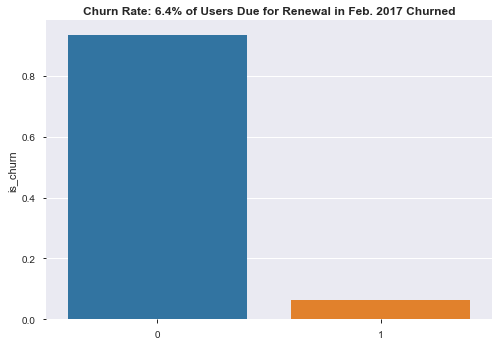

In [146]:
# Look at target variable's distribution:
target = 'is_churn'

sns.barplot(x=train_all[target].value_counts().index, 
            y=train_all[target].value_counts(normalize=True))
plt.title(f"Churn Rate: {train_all[target].value_counts(normalize=True).loc[1] * 100:.1f}% of Users Due for Renewal in Feb. 2017 Churned", fontweight="bold")
plt.show()

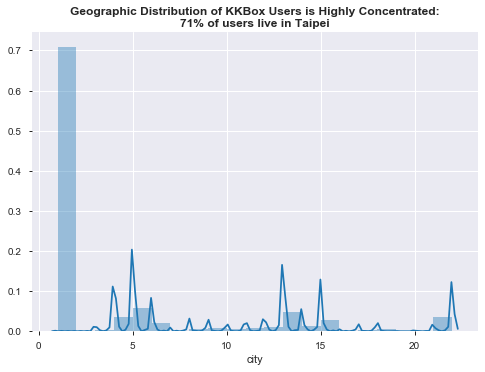

In [147]:
# Members by city: Almost all (70%) live in Taipei:
cities_all = pd.DataFrame(members_all['city'].value_counts(dropna=False))
cities_all['%'] = members_all['city'].value_counts(normalize=True, dropna=False)
cities_all.reset_index(inplace=True)
cities_all.rename(columns={'index': 'city', 'city': 'customers'}, inplace=True)

sns.distplot(members_all['city'], bins=members_all['city'].nunique())
plt.title(f"Geographic Distribution of KKBox Users is Highly Concentrated:\n{cities_all[cities_all['city'] == 1]['%'][0] * 100:.0f}% of users live in Taipei", fontweight="bold")
plt.show()

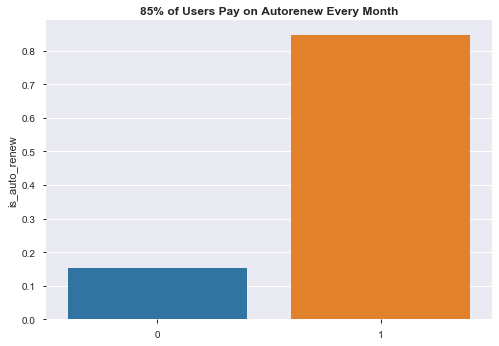

In [148]:
# Autorenew: % of customers who pay on autorenew:
autorenew_dist = transactions_all['is_auto_renew'].value_counts(normalize=True)
sns.barplot(x=autorenew_dist.index, 
            y=autorenew_dist);
plt.title(f"{autorenew_dist.loc[1] * 100:.0f}% of Users Pay on Autorenew Every Month", fontweight="bold")
plt.show()

In [149]:
user_logs_all.columns

Index(['msno', 'date', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100',
       'num_unq', 'total_secs'],
      dtype='object')

In [150]:
user_logs

msno       date  num_25  \
117        9IzdFLkXN+UUsGLLC3C5cEaChLBk/NhJWIwM+CvsMbE= 2016-07-13       4   
118        9IzdFLkXN+UUsGLLC3C5cEaChLBk/NhJWIwM+CvsMbE= 2016-09-16       1   
119        9IzdFLkXN+UUsGLLC3C5cEaChLBk/NhJWIwM+CvsMbE= 2016-11-30       1   
120        9IzdFLkXN+UUsGLLC3C5cEaChLBk/NhJWIwM+CvsMbE= 2017-02-20       3   
238        rE5wSmHEF1Dhu55zhkiGB1HvotdlSHcIMGXv6VcqO2A= 2016-07-18       5   
...                                                 ...        ...     ...   
410502865  om44XwtYda63wvLbDwumxJ4WhoOLQHRX8ywVXAh0iUo= 2017-03-04       0   
410502869  6K5nZi/IssJgXiCfyC9PQwbWCiVw6I2xr4r2Ex0LlJ8= 2017-03-16       1   
410502877  734jT0bTvkwtZ+mJ5yix4IC719mJbtbmyORMYoVN1i8= 2017-03-27       1   
410502880  sgyU6vlumsjUe0Y+ws06x7exacC9E+N/w58GukDoFKA= 2017-03-01       0   
410502891  JRtjHLUutW148YxrUgPuJt1yEvgSzq08dfxc9AsrY40= 2017-03-17       0   

           num_50  num_75  num_985  num_100  num_unq  total_secs  
117             0       1        0        4        8    1202.130  
118             0       0        0        1        2     374.743  
119             0       0        0        6        6    2483.134  
120             1       0        1        6        9    2040.429  
238             1       2        4        5       12    2767.641  
...           ...     ...      ...      ...      ...         ...  
410502865       0       0        0        1        1    2004.000  
410502869       0       0        0       10        1    2523.635  
410502877       0       0        0        1        2     253.309  
410502880       0       0        0        1        1     239.072  
410502891       0       0        0        1        1     315.791  

[7710158 rows x 9 columns]

In [151]:
test257 = user_logs_all.describe()

In [152]:
test257

date        num_25        num_50        num_75       num_985  \
count  1.551496e+08  1.551496e+08  1.551496e+08  1.551496e+08  1.551496e+08   
mean   2.016408e+07  6.283534e+00  1.540902e+00  9.811706e-01  1.079944e+00   
std    4.372011e+03  1.168088e+01  3.148875e+00  1.672755e+00  1.932248e+00   
min    2.016070e+07  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.016091e+07  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    2.016112e+07  2.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00   
75%    2.017012e+07  7.000000e+00  2.000000e+00  1.000000e+00  1.000000e+00   
max    2.017033e+07  1.840000e+02  6.200000e+01  2.400000e+01  3.900000e+01   

            num_100       num_unq    total_secs  
count  1.551496e+08  1.551496e+08  1.551496e+08  
mean   2.989018e+01  2.923021e+01  7.871495e+03  
std    3.763695e+01  3.154649e+01  9.273321e+03  
min    0.000000e+00  1.000000e+00  1.000000e-03  
25%    7.000000e+00  8.000000e+00  1.943109e+03  
50%    1.700000e+01  1.900000e+01  4.619944e+03  
75%    3.700000e+01  3.900000e+01  9.996696e+03  
max    3.840000e+02  5.010000e+02  8.554460e+04

In [153]:
train.describe()

is_churn          city           age  registered_via    gender_nan  \
count  28406.000000  25440.000000  13230.000000    25440.000000  28406.000000   
mean       0.553052      6.603105     28.401436        6.636714      0.534042   
std        0.497186      6.588109      8.765207        2.244941      0.498849   
min        0.000000      1.000000     12.000000        3.000000      0.000000   
25%        0.000000      1.000000     22.000000        4.000000      0.000000   
50%        1.000000      4.000000     27.000000        7.000000      1.000000   
75%        1.000000     13.000000     33.000000        9.000000      1.000000   
max        1.000000     22.000000     94.000000       13.000000      1.000000   

        gender_male  gender_female  total_days_since_joined  cost_per_month  \
count  28406.000000   28406.000000             25440.000000    28251.000000   
mean       0.242695       0.223263              1201.272995      131.667870   
std        0.428720       0.416440              1061.547578       35.408764   
min        0.000000       0.000000               -19.000000        0.000000   
25%        0.000000       0.000000               382.000000       99.000000   
50%        0.000000       0.000000               929.500000      149.000000   
75%        0.000000       0.000000              1705.000000      149.000000   
max        1.000000       1.000000              4695.000000      180.000000   

       on_auto_renew  ...  songs_affinity_nps_last_6_months  \
count   28252.000000  ...                      23784.000000   
mean        0.657086  ...                          0.462686   
std         0.474691  ...                          0.357550   
min         0.000000  ...                         -1.000000   
25%         0.000000  ...                          0.278540   
50%         1.000000  ...                          0.534483   
75%         1.000000  ...                          0.724197   
max         1.000000  ...                          1.000000   

       songs_percent_loved_last_month  songs_percent_loved_last_6_months  \
count                    22147.000000                       23784.000000   
mean                         0.724417                           0.715313   
std                          0.195977                           0.186308   
min                          0.000000                           0.000000   
25%                          0.619202                           0.619048   
50%                          0.764706                           0.752750   
75%                          0.872679                           0.851244   
max                          1.000000                           1.000000   

       songs_percent_disliked_last_month  \
count                       22147.000000   
mean                            0.193570   
std                             0.156993   
min                             0.000000   
25%                             0.080000   
50%                             0.156550   
75%                             0.267221   
max                             1.000000   

       songs_percent_disliked_last_6_months  avg_active_days_L30_last_month  \
count                          23784.000000                    23909.000000   
mean                               0.200143                       15.052783   
std                                0.147572                        9.713289   
min                                0.000000                        0.000000   
25%                                0.096110                        6.000000   
50%                                0.167565                       15.000000   
75%                                0.268040                       24.000000   
max                                1.000000                       30.000000   

       avg_active_days_L30_last_6_months  avg_min_per_song  \
count                       23909.000000      22147.000000   
mean                           83.297210          3.130855   
std                  

### Follow 1 single user for reference [?? To do: remove ??]

In [154]:
single_user_msno = train.sample(n=1, replace=False) # random_state=42
single_user_msno = list(single_user_msno['msno'])

In [155]:
single_user_msno

['D4f4Nist6ikDzZr7iyxGN/eAQDskwbtw/5rlcPcqXHg=']

In [156]:
train[train['msno'].isin(single_user_msno)]

msno  is_churn  city   age  \
11947  D4f4Nist6ikDzZr7iyxGN/eAQDskwbtw/5rlcPcqXHg=         1  13.0  32.0   

       gender  registered_via registration_init_time  gender_nan  gender_male  \
11947  female             9.0             2009-11-22           0            0   

       gender_female  ...  avg_active_days_L30_last_month  \
11947              1  ...                            29.0   

       avg_active_days_L30_last_6_months  is_MAU_last_month  \
11947                              126.0               True   

       is_WAU_last_month is_WAU_last_6_months  is_DAU_last_month  \
11947               True                 True               True   

      is_DAU_last_6_months  avg_min_per_song last_6_months_avg_monthly_mins  \
11947                False           3.55796                    2970.907169   

       last_month_vs_6_month_avg  
11947                   1.623946  

[1 rows x 46 columns]

In [157]:
members[members['msno'].isin(single_user_msno)]

msno  city   age  gender  \
1495763  D4f4Nist6ikDzZr7iyxGN/eAQDskwbtw/5rlcPcqXHg=    13  32.0  female   

         registered_via registration_init_time  
1495763             9.0             2009-11-22

In [158]:
transactions[transactions['msno'].isin(single_user_msno)].sort_values(by='transaction_date', ascending=True)

msno  payment_method_id  \
1545161   D4f4Nist6ikDzZr7iyxGN/eAQDskwbtw/5rlcPcqXHg=                 36   
7997138   D4f4Nist6ikDzZr7iyxGN/eAQDskwbtw/5rlcPcqXHg=                 36   
8318940   D4f4Nist6ikDzZr7iyxGN/eAQDskwbtw/5rlcPcqXHg=                 36   
1823858   D4f4Nist6ikDzZr7iyxGN/eAQDskwbtw/5rlcPcqXHg=                 36   
1000739   D4f4Nist6ikDzZr7iyxGN/eAQDskwbtw/5rlcPcqXHg=                 36   
7181932   D4f4Nist6ikDzZr7iyxGN/eAQDskwbtw/5rlcPcqXHg=                 36   
21841867  D4f4Nist6ikDzZr7iyxGN/eAQDskwbtw/5rlcPcqXHg=                 36   

          payment_plan_days  plan_list_price  actual_amount_paid  \
1545161                  30              180                 180   
7997138                  30              180                 180   
8318940                  30              180                 180   
1823858                  30              180                 180   
1000739                  30              180                 180   
7181932                  30              180                 180   
21841867                 30              180                 180   

          is_auto_renew transaction_date membership_expire_date  is_cancel  \
1545161               0       2016-09-24             2016-10-24          0   
7997138               0       2016-10-29             2016-11-28          0   
8318940               0       2016-11-29             2016-12-29          0   
1823858               0       2016-12-28             2017-01-28          0   
1000739               0       2017-01-29             2017-02-28          0   
7181932               0       2017-01-29             2017-03-30          0   
21841867              0       2017-03-30             2017-04-29          0   

          actual_amount_paid_per_30_days  
1545161                            180.0  
7997138                            180.0  
8318940                            180.0  
1823858                            180.0  
1000739                            180.0  
7181932                            180.0  
21841867                           180.0

In [159]:
user_logs[user_logs['msno'].isin(single_user_msno)].sort_values(by='date', ascending=True)

msno       date  num_25  \
212802865  D4f4Nist6ikDzZr7iyxGN/eAQDskwbtw/5rlcPcqXHg= 2016-09-24     146   
220647735  D4f4Nist6ikDzZr7iyxGN/eAQDskwbtw/5rlcPcqXHg= 2016-09-25      21   
234917741  D4f4Nist6ikDzZr7iyxGN/eAQDskwbtw/5rlcPcqXHg= 2016-09-26      20   
239508553  D4f4Nist6ikDzZr7iyxGN/eAQDskwbtw/5rlcPcqXHg= 2016-09-27     126   
249427061  D4f4Nist6ikDzZr7iyxGN/eAQDskwbtw/5rlcPcqXHg= 2016-09-28      28   
...                                                 ...        ...     ...   
400832720  D4f4Nist6ikDzZr7iyxGN/eAQDskwbtw/5rlcPcqXHg= 2017-03-27      12   
398830773  D4f4Nist6ikDzZr7iyxGN/eAQDskwbtw/5rlcPcqXHg= 2017-03-28      11   
408778124  D4f4Nist6ikDzZr7iyxGN/eAQDskwbtw/5rlcPcqXHg= 2017-03-29      11   
392846056  D4f4Nist6ikDzZr7iyxGN/eAQDskwbtw/5rlcPcqXHg= 2017-03-30       6   
403527435  D4f4Nist6ikDzZr7iyxGN/eAQDskwbtw/5rlcPcqXHg= 2017-03-31       2   

           num_50  num_75  num_985  num_100  num_unq  total_secs  
212802865      12       1        0        3      143    3851.322  
220647735       4      12       11       36       72   13620.779  
234917741       1       4        2        7       34    2840.341  
239508553      19       7        3       30      168   13085.022  
249427061       2       0        3       18       43    5626.349  
...           ...     ...      ...      ...      ...         ...  
400832720       2       0        0       21       24    5835.199  
398830773       1       0        0       14       25    3710.589  
408778124       1       3        0       17       30    4202.388  
392846056       1       2        0       12       21    3127.405  
403527435       2       0        1       10       13    2675.998  

[185 rows x 9 columns]

# **Feature Selection:**

In [160]:
train

msno  is_churn  city   age  \
0      G8FefH0MNOuCUk6AqdLVWiyPCTaN/bZGeXJyShO7+ac=         1   1.0   NaN   
1      p88PKOPAekKAMRcfJFLqypW+29oypZgu7OhM+OMhe7Y=         0   1.0   NaN   
2      fPxGxUHllzIDKkUCapeNtdvxe1KeiRE/+f5ZIIVXxDM=         0  13.0  28.0   
3      Tywb25GQ2u75kZ9YymYHp1bMWveZBTjfjnoDpmxt3Ew=         0   4.0  31.0   
4      rffmmuTprm+iFppWr9XILBFp4wUjaRPXrYmj8ShugIE=         1  22.0  24.0   
...                                             ...       ...   ...   ...   
28401  wsdADq5adOdPh4tOENc8EYhbr+AvVDGcHAlgaAFBiW0=         1   1.0   NaN   
28402  tm1OLwLyrnJLeICiYzwFNqShBpM6VyXn6lsmcq06k2U=         1   8.0  27.0   
28403  8jngFyoi9v5EzuOQ+/lW6lM02g5qlp9e1bigtd2Tn1c=         1   8.0  17.0   
28404  V0Lzl4d7fO2URaS/YQpS+XflsDp910DX4t9uXhtDdO0=         0  14.0   NaN   
28405  Yb7q5jT9ADrpxZQAAyFRFltq2OlSo0gBt1rFWHCKDpc=         1   1.0   NaN   

       gender  registered_via registration_init_time  gender_nan  gender_male  \
0         NaN             7.0             2015-11-02           1            0   
1         NaN             7.0             2012-01-23           1            0   
2        male             7.0             2015-09-13           0            1   
3      female             3.0             2012-10-02           0            0   
4        male             3.0             2014-12-18           0            1   
...       ...             ...                    ...         ...          ...   
28401     NaN             7.0             2012-05-01           1            0   
28402    male             4.0             2016-10-01           0            1   
28403    male             4.0             2015-12-26           0            1   
28404     NaN             3.0             2014-07-03           1            0   
28405     NaN             4.0             2017-01-09           1            0   

       gender_female  ...  avg_active_days_L30_last_month  \
0                  0  ...                             0.0   
1                  0  ...                            21.0   
2                  0  ...                             1.0   
3                  1  ...                             6.0   
4                  0  ...                             5.0   
...              ...  ...                             ...   
28401              0  ...                             0.0   
28402              0  ...                            27.0   
28403              0  ...                            29.0   
28404              0  ...                            20.0   
28405              0  ...                            14.0   

       avg_active_days_L30_last_6_months  is_MAU_last_month  \
0                                    3.0              False   
1                                   30.0               True   
2                                   17.0               True   
3                                   51.0               True   
4                                    5.0               True   
...                                  ...                ...   
28401                               99.0              False   
28402                               69.0               True   
28403                              145.0               True   
28404                              135.0               True   
28405                               14.0               True   

       is_WAU_last_month is_WAU_last_6_months  is_DAU_last_month  \
0                  False                False              False   
1                   True                 True              False   
2                  False                False              False   
3                   True                 True              False   
4                   True                False              False   
...                  ...                  ...                ...   
28401              False                 True              False   
28402               True                  NaN               True   
28403               True                 True  

In [161]:
val

msno  is_churn  city   age  \
0      Bu3vaBx1CkanJ9UmbJk70x3qIc1WBkVeOkGGwB+FAVc=         0   1.0   NaN   
1      Zx6c9VSBnj0O8L4SuNXpu/yV5QYo7XSvv1VjSImaF7k=         0   NaN   NaN   
2      j9T1MdUTuRCURN/TPotX1b2Jhd6uGChCF63RbkVToZI=         0   4.0  30.0   
3      KAmIIc7EsTcjkqc16YmKJsdfAoUBN2NzJLSiej5TFt4=         1   1.0   NaN   
4      gp5uBnYOMtyCH0I0OWD+TdSp3cSeD13gJHotGtf1wiY=         0   1.0   NaN   
...                                             ...       ...   ...   ...   
27491  oCbf8k1tjqUO+J85P04tz41Gnqx8gtGhkNZ9ErVJUgI=         0   1.0   NaN   
27492  k/IiZajRrcSlM7OcWd/u/35leOj3mlJbQGnnRTWrcI4=         0  13.0  23.0   
27493  JS1TYej7BODmljrJVpIplRQIoOhM08NckCx5Zdi2RGc=         0   NaN   NaN   
27494  mA8MU6polbbrpKaLnHkbsjsyfTHblB7TGGT5fYTSfF8=         0  14.0  20.0   
27495  Zjcw2eJMgukydwJpa3vs/ayfPusdJStL7UuzvgffGhc=         0  12.0  25.0   

       gender  registered_via registration_init_time  gender_nan  gender_male  \
0         NaN             4.0             2016-04-29           1            0   
1         NaN             NaN                    NaT           1            0   
2        male             9.0             2011-03-07           0            1   
3         NaN             4.0             2016-04-30           1            0   
4         NaN             7.0             2013-02-03           1            0   
...       ...             ...                    ...         ...          ...   
27491     NaN             7.0             2011-06-08           1            0   
27492  female             9.0             2012-11-03           0            0   
27493     NaN             NaN                    NaT           1            0   
27494    male             3.0             2014-05-05           0            1   
27495    male             9.0             2011-08-15           0            1   

       gender_female  ...  avg_active_days_L30_last_month  \
0                  0  ...                            29.0   
1                  0  ...                             NaN   
2                  0  ...                            23.0   
3                  0  ...                            15.0   
4                  0  ...                             0.0   
...              ...  ...                             ...   
27491              0  ...                            29.0   
27492              1  ...                            30.0   
27493              0  ...                             NaN   
27494              0  ...                            29.0   
27495              0  ...                            28.0   

       avg_active_days_L30_last_6_months  is_MAU_last_month  \
0                                  127.0               True   
1                                    NaN              False   
2                                  158.0               True   
3                                   40.0               True   
4                                   19.0              False   
...                                  ...                ...   
27491                              178.0               True   
27492                              149.0               True   
27493                                NaN              False   
27494                              168.0               True   
27495                              152.0               True   

       is_WAU_last_month is_WAU_last_6_months  is_DAU_last_month  \
0                   True                 True               True   
1                  False                  NaN              False   
2                   True                 True               True   
3                   True                 True              False   
4                  False                False              False   
...                  ...                  ...                ...   
27491               True                 True               True   
27492               True                 True               True   
27493              False                  NaN  

**Final Features Selected:**

In [162]:
# Define final features and target, based on above findings re feature importances:
target = 'is_churn'

features = set(train.columns)
to_remove = set([
                 # Target variable:
                 target, 
                 
                 # Irrelevant information and/or no variance:
                 # [?? To do ??]
                 'msno', 'registration_init_time', 'gender', 
                 
                 # Redundant (near copies of info in other columns):
                 # [?? To do ??]
                 
                 # Very low permutation importances:
                 # [?? To do ??]
                 
                 # Far too many NaNs --> better to drop than impute:
                 # Removed: 'age' has >50% NaNs, but nonetheless helps our models a lot (esp. for TPR/recall), so 
                 # decided to keep despite the NaNs.
                 ])
features = list(features - to_remove)

# Features matrices and target vectors for train and val sets:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
# X_test = test[features]  # [?? To do: Reinstate test here and everywhere above!! ??]

# # Check to make sure X matrices have the same numbers of columns:
# assert X_train.shape[1] == X_val.shape[1] == X_test.shape[1]

In [163]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape
# X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape

((28406, 42), (27496, 42), (28406,), (27496,))

In [164]:
X_train.columns

Index(['total_mins_last_month', 'songs_affinity_nps_last_month',
       'num_unique_last_6_months', 'registered_via', 'is_MAU_last_month',
       'on_auto_renew', 'avg_active_days_L30_last_month',
       'is_WAU_last_6_months', 'total_mins_last_6_months',
       'total_days_since_joined', 'num_songs_listened_last_6_months', 'age',
       'churned_full_in_past', 'songs_percent_loved_last_month',
       'churn_returned_in_past', 'num_songs_finished_last_month',
       'last_month_vs_6_month_avg', 'gender_male',
       'last_6_months_avg_monthly_mins', 'city', 'churned_full_num_times',
       'churn_returned_num_times', 'is_DAU_last_6_months',
       'payment_method_latest', 'songs_affinity_nps_last_6_months',
       'num_songs_started_last_6_months', 'avg_min_per_song',
       'churned_any_num_times', 'churned_any_in_past',
       'songs_percent_loved_last_6_months',
       'songs_percent_disliked_last_month', 'num_unique_last_month',
       'gender_nan', 'gender_female', 'num_songs_fini

# **Baselines:**

### Baseline 1:  Dummy Model:  Majority Classifier:

In [165]:
y_train.value_counts(dropna=False, normalize=True)

1    0.553052
0    0.446948
Name: is_churn, dtype: float64

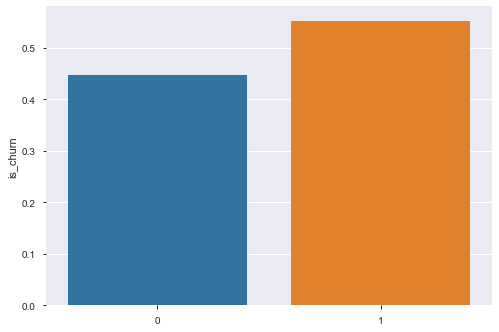

In [166]:
sns.barplot(x=y_train.value_counts(normalize=True).index, 
            y=y_train.value_counts(normalize=True));

In [274]:
majority_class = y_train.mode()[0]

In [275]:
# Get relevant score for our Baseline 1: Majority Classifier dummy model:
y_true_val = y_val
y_pred_b1_val = [majority_class] * len(y_val)

# Get confusion matrix:
cm_b1_val = pd.DataFrame(confusion_matrix(y_true_val, y_pred_b1_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_b1_val.loc['actual_1', 'pred_1']
FN = cm_b1_val.loc['actual_1', 'pred_0']
FP = cm_b1_val.loc['actual_0', 'pred_1']
TN = cm_b1_val.loc['actual_0', 'pred_0']

print('\nBaseline 1:  Majority Classifier Performance:\n')
print(f'Accuracy: {accuracy_score(y_true_val, y_pred_b1_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_val, y_pred_b1_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'False Negative Rate ("Miss Rate"): {FN / (FN + TP):.3f}')
y_pred_b1_val_proba = np.full(shape=(len(y_val), 2), fill_value=[1.0, 0.0])
print(f'Log loss (negative): {log_loss(y_true_val, y_pred_b1_val_proba, eps=10**-15):.3f}')
cm_b1_val


Baseline 1:  Majority Classifier Performance:

Accuracy: 0.063
Recall : 1.000
False Negative Rate ("Miss Rate"): 0.000
Log loss (negative): 2.176


pred_0  pred_1
actual_0       0   25764
actual_1       0    1732

In [169]:
# Confusion matrix, normalized:
cm_b1_val / cm_b1_val.sum().sum()

pred_0    pred_1
actual_0     0.0  0.937009
actual_1     0.0  0.062991

In [170]:
# # Alternate version using sklearn's DummyClassifier class:

# # Get relevant score for our Baseline 1: Majority Classifier dummy model:

# # Import estimator class:
# from sklearn.dummy import DummyClassifier

# # Initialize estimator class:
# b1_dummyclassifier =  DummyClassifier(strategy='most_frequent', random_state=42)

# # Preprocessing:  No need to encode, impute or scale here.

# # Fit model to training data:
# b1_dummyclassifier.fit(X_train, y_train)

# # Apply to val set and get performance metrics:
# y_true_val = y_val
# y_pred_b1_val_dc = b1_dummyclassifier.predict(X_val)


# # Get confusion matrix:
# cm_b1_val_dc = pd.DataFrame(confusion_matrix(y_true_val, y_pred_b1_val_dc), 
#                         index=['actual_0', 'actual_1'], 
#                         columns=['pred_0', 'pred_1'])
# TP = cm_b1_val.loc['actual_1', 'pred_1']
# FN = cm_b1_val.loc['actual_1', 'pred_0']
# FP = cm_b1_val.loc['actual_0', 'pred_1']
# TN = cm_b1_val.loc['actual_0', 'pred_0']

# print('Baseline 1:  Majority Classifier Performance:')
# print(f'Accuracy: {accuracy_score(y_true_val, y_pred_b1_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
# print(f"Recall 2: {recall_score(y_true_val, y_pred_b1_val, average='binary'):.3f}")  # TP / (TP + FN)
# print(f'False Negative Rate ("Miss Rate"): {FN / (FN + TP):.3f}')
# # [?? To do:  Log loss ??]
# print(f'Log loss (negative): {log_loss(y_true_val, b1_dummyclassifier.predict_proba(X_val), eps=10**-15):.3f}')

### Baseline 2:  Simple Single Decision Tree Classifier:

In [171]:
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    DecisionTreeClassifier(min_samples_leaf=2, random_state=42)
)

# Fit on training data:
pipeline.fit(X_train, y_train)

print('\nBaseline #2: Single Decision Tree Classifier: Performance:\n')

# --------- TRAIN --------------------------------------------
# Performance on training data:
y_true_b2_train = y_train
y_pred_b2_train = pipeline.predict(X_train)

# Get TP, FN, FP, TN:
cm_b2_train = pd.DataFrame(confusion_matrix(y_true_b2_train, y_pred_b2_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_b2_train.loc['actual_1', 'pred_1']
FN = cm_b2_train.loc['actual_1', 'pred_0']
FP = cm_b2_train.loc['actual_0', 'pred_1']
TN = cm_b2_train.loc['actual_0', 'pred_0']

print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_b2_train, y_pred_b2_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_b2_train, y_pred_b2_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_b2_train_proba = pipeline.predict_proba(X_train)
print(f'Log loss (negative): {log_loss(y_true_b2_train, y_pred_b2_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_b2_train / cm_b2_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_b2_train / cm_b2_train.sum().sum()

# ---------- VAL ---------------------------------------------
# Apply to val and get score:
y_true_b2_val = y_val
y_pred_b2_val = pipeline.predict(X_val)

# Get TP, FN, FP, TN:
cm_b2_val = pd.DataFrame(confusion_matrix(y_true_b2_val, y_pred_b2_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_b2_val.loc['actual_1', 'pred_1']
FN = cm_b2_val.loc['actual_1', 'pred_0']
FP = cm_b2_val.loc['actual_0', 'pred_1']
TN = cm_b2_val.loc['actual_0', 'pred_0']

print('\nVALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_b2_val, y_pred_b2_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_b2_val, y_pred_b2_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_b2_val_proba = pipeline.predict_proba(X_val)
print(f'Log loss (negative): {log_loss(y_true_b2_val, y_pred_b2_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_b2_val / cm_b2_val.sum().sum()).sum().sum(), 10) == 1.0
cm_b2_val / cm_b2_val.sum().sum()

# [?? To do:  Add in cross-validation avg. score using cross_val_score ??]
# print('CROSS-VALIDATED AVG. ACROSS MULTIPLE TRAIN/VAL SPLITS:')
# [?? To do:  Add in cross-validation avg. score using cross_val_score ??]


Baseline #2: Single Decision Tree Classifier: Performance:

TRAINING SET:

Accuracy: 0.935
Recall : 0.909
"Miss Rate" (FNR): 0.091
Log loss (negative): 0.109


VALIDATION SET:

Accuracy: 0.741
Recall : 0.624
"Miss Rate" (FNR): 0.376
Log loss (negative): 7.486

Confusion matrix, normalized:


pred_0    pred_1
actual_0  0.702211  0.234798
actual_1  0.023713  0.039278

In [172]:
# # Plot tree
# # https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
# import graphviz
# from sklearn.tree import export_graphviz

# b2_dt_estimator = pipeline.named_steps['decisiontreeclassifier']
# encoder = pipeline.named_steps['ordinalencoder']
# encoded_columns = encoder.transform(X_val).columns

# dot_data = export_graphviz(b2_dt_estimator, 
#                            out_file=None, 
#                            max_depth=3, 
#                            feature_names=encoded_columns,
#                            class_names=b2_dt_estimator.classes_, 
#                            impurity=False, 
#                            filled=True, 
#                            proportion=True, 
#                            rounded=True)   
# display(graphviz.Source(dot_data))

In [173]:
# # Feature Importances:
# b2_dt_feat_importances = pd.Series(b2_dt_estimator.feature_importances_, encoded_columns)

# # Plot on chart:
# n = len(encoded_columns)
# plt.figure(figsize=(10, n/2))
# b2_dt_feat_importances.sort_values().plot.barh(color='grey')
# plt.title('Feature Importances: Baseline #2: Single DecisionTree Model')
# plt.show()

# **Models/Predictions:**

### Model 1:  Logistic Regression Classifier w/ Cross-validation:

In [301]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    LogisticRegressionCV(multi_class='ovr', 
                         class_weight='balanced', 
                         cv=StratifiedKFold(n_splits=5), 
                         scoring='neg_log_loss', 
                         solver='lbfgs', 
                         n_jobs=-2, 
                         random_state=42)
)

# Fit on training data:
pipeline.fit(X_train, y_train)


print('\nModel #1: Linear Model: Logistic Regression w/ CV Performance:\n')

# --------- TRAIN --------------------------------------------
# Performance on training data:
y_true_m1_train = y_train
y_pred_m1_train = pipeline.predict(X_train)

# Get TP, FN, FP, TN:
cm_m1_train = pd.DataFrame(confusion_matrix(y_true_m1_train, y_pred_m1_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m1_train.loc['actual_1', 'pred_1']
FN = cm_m1_train.loc['actual_1', 'pred_0']
FP = cm_m1_train.loc['actual_0', 'pred_1']
TN = cm_m1_train.loc['actual_0', 'pred_0']

print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m1_train, y_pred_m1_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m1_train, y_pred_m1_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m1_train_proba = pipeline.predict_proba(X_train)
print(f'Log loss (negative): {log_loss(y_true_m1_train, y_pred_m1_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_m1_train / cm_m1_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_m1_train / cm_m1_train.sum().sum()

# ---------- VAL ---------------------------------------------
# Apply to val and get score:
y_true_m1_val = y_val
y_pred_m1_val = pipeline.predict(X_val)

# Get TP, FN, FP, TN:
cm_m1_val = pd.DataFrame(confusion_matrix(y_true_m1_val, y_pred_m1_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m1_val.loc['actual_1', 'pred_1']
FN = cm_m1_val.loc['actual_1', 'pred_0']
FP = cm_m1_val.loc['actual_0', 'pred_1']
TN = cm_m1_val.loc['actual_0', 'pred_0']

print('\nVALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m1_val, y_pred_m1_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m1_val, y_pred_m1_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m1_val_proba = pipeline.predict_proba(X_val)
print(f'Log loss (negative): {log_loss(y_true_m1_val, y_pred_m1_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_m1_val / cm_m1_val.sum().sum()).sum().sum(), 10) == 1.0
cm_m1_val / cm_m1_val.sum().sum()

# [?? To do:  Add in cross-validation avg. score using cross_val_score ??]
# print('CROSS-VALIDATED AVG. ACROSS MULTIPLE TRAIN/VAL SPLITS:')
# [?? To do:  Add in cross-validation avg. score using cross_val_score ??]

/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Model #1: Linear Model: Logistic Regression w/ CV Performance:

TRAINING SET:

Accuracy: 0.748
Recall : 0.646
"Miss Rate" (FNR): 0.354
Log loss (negative): 0.516


VALIDATION SET:

Accuracy: 0.858
Recall : 0.666
"Miss Rate" (FNR): 0.334
Log loss (negative): 0.504

Confusion matrix, normalized:


pred_0    pred_1
actual_0  0.815828  0.121181
actual_1  0.021058  0.041933

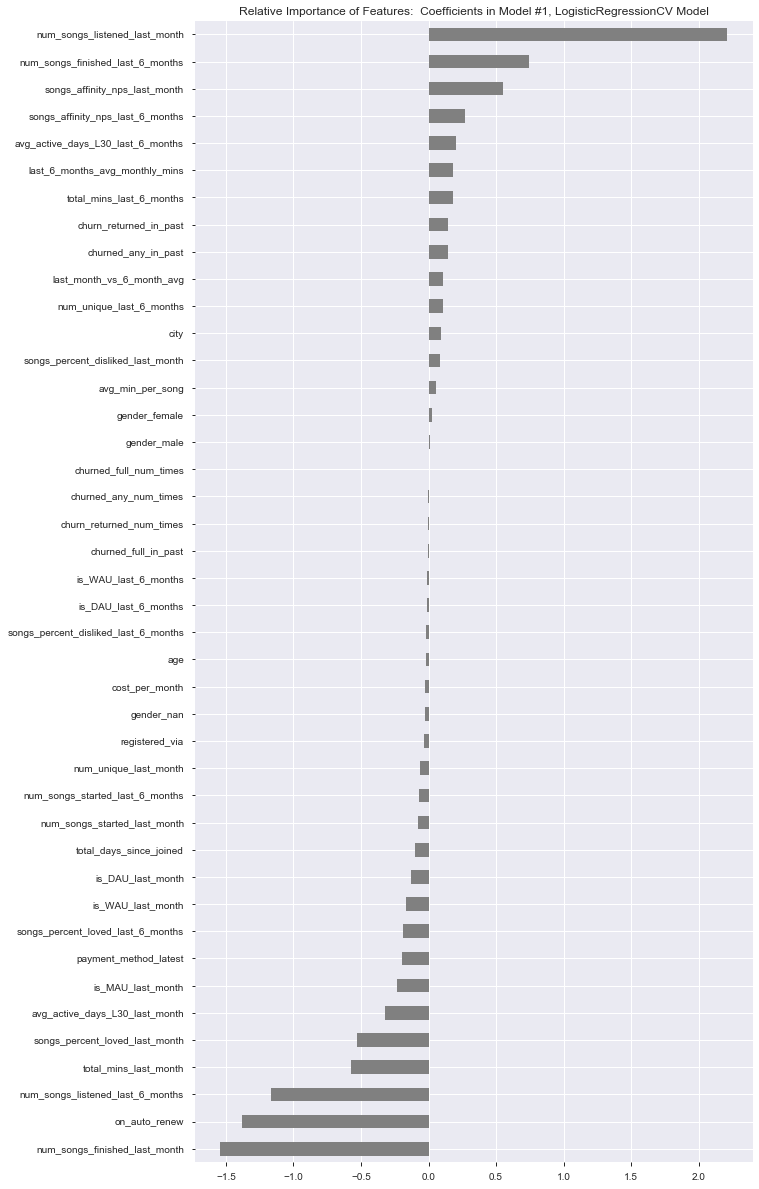

In [302]:
# Feature importances:  Get coefficients of LogisticRegressionCV model to see 
# which features have more of an impact on the model's predictions:
%matplotlib inline
import matplotlib.pyplot as plt

m1_logregcv_coeffs = pipeline.named_steps['logisticregressioncv'].coef_[0]
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
coefficients_table = pd.Series(m1_logregcv_coeffs, encoded_columns)

# Plot on chart:
n = len(encoded_columns)
plt.figure(figsize=(10, n/2))
coefficients_table.sort_values().plot.barh(color='grey')
plt.title('Relative Importance of Features:  Coefficients in Model #1, LogisticRegressionCV Model')
plt.show()

### Model 2: RandomForest Classifier:

In [303]:
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, min_samples_leaf=2, n_jobs=-1, random_state=42)
)

# Fit on training data:
pipeline.fit(X_train, y_train)

# Apply to train and get score:
y_true_m2_train = y_train
y_pred_m2_train = pipeline.predict(X_train)

# Get TP, FN, FP, TN:
cm_m2_train = pd.DataFrame(confusion_matrix(y_true_m2_train, y_pred_m2_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m2_train.loc['actual_1', 'pred_1']
FN = cm_m2_train.loc['actual_1', 'pred_0']
FP = cm_m2_train.loc['actual_0', 'pred_1']
TN = cm_m2_train.loc['actual_0', 'pred_0']

print('\nModel #2: RandomForestClassifier Performance:\n')

# --------- TRAIN --------------------------------------------
print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m2_train, y_pred_m2_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m2_train, y_pred_m2_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m2_train_proba = pipeline.predict_proba(X_train)
print(f'Log loss (negative): {log_loss(y_true_m2_train, y_pred_m2_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_m2_train / cm_m2_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_m2_train / cm_m2_train.sum().sum()

# ---------- VAL ---------------------------------------------
# Apply to val and get score:
y_true_m2_val = y_val
y_pred_m2_val = pipeline.predict(X_val)

# Get TP, FN, FP, TN:
cm_m2_val = pd.DataFrame(confusion_matrix(y_true_m2_val, y_pred_m2_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m2_val.loc['actual_1', 'pred_1']
FN = cm_m2_val.loc['actual_1', 'pred_0']
FP = cm_m2_val.loc['actual_0', 'pred_1']
TN = cm_m2_val.loc['actual_0', 'pred_0']

print('VALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m2_val, y_pred_m2_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m2_val, y_pred_m2_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m2_val_proba = pipeline.predict_proba(X_val)
print(f'Log loss (negative): {log_loss(y_true_m2_val, y_pred_m2_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_m2_val / cm_m2_val.sum().sum()).sum().sum(), 10) == 1.0
cm_m2_val / cm_m2_val.sum().sum()


Model #2: RandomForestClassifier Performance:

TRAINING SET:

Accuracy: 0.951
Recall : 0.946
"Miss Rate" (FNR): 0.054
Log loss (negative): 0.207

VALIDATION SET:

Accuracy: 0.830
Recall : 0.733
"Miss Rate" (FNR): 0.267
Log loss (negative): 0.478

Confusion matrix, normalized:


pred_0    pred_1
actual_0  0.783459  0.153550
actual_1  0.016839  0.046152

**RandomForest w/ Optimized Hyperparameters:**

In [304]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Separate transformers/pipeline from XGBClassifier model, so we can later use eli5 to get permutation importances:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

m2_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

class_weight_1s = train[target].value_counts(normalize=True)[0] / train[target].value_counts(normalize=True)[1]
class_weight_1s_range = [class_weight_1s*0.6, class_weight_1s*0.8, class_weight_1s, class_weight_1s*1.2, class_weight_1s*1.4]

param_distributions_rf = {
    'class_weight': ['balanced', None, {0:1, 1:class_weight_1s_range[0]}, {0:1, 1:class_weight_1s_range[1]}, {0:1, 1:class_weight_1s_range[2]}, {0:1, 1:class_weight_1s_range[3]}, {0:1, 1:class_weight_1s_range[4]}], 
    'max_depth': sp_randint(3, 40), 
    'min_samples_leaf': sp_randint(1, 8), 
    'bootstrap': [True, False], 
    'criterion': ['gini', 'entropy'], 
    'warm_start': [False, True]
}

cv = StratifiedKFold(n_splits=3, random_state=42)

random_search_rf = RandomizedSearchCV(
    m2_rf, 
    param_distributions=param_distributions_rf, 
    n_iter=30, 
    scoring='neg_log_loss',  # Other options: 'recall', 'accuracy', 'roc_auc', 
    # [?? To do: above for scoring=, try to (1) use 'neg_log_loss' (requires predict_proba), (2) use multiple scoring metrics together (there is a way: see line below), (3) see if worthwhile to custom define FNR (miss rate) too ??]
    # multi-metric evaluation, link 1: https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
    # multi-metric eval, link 2: https://scikit-learn.org/stable/modules/grid_search.html#multimetric-grid-search
    # Making a custom scoring method (maybe for FNR/miss rate)?:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer
    cv=cv, 
    verbose=True, 
    return_train_score=True, 
    n_jobs=-2, 
    pre_dispatch=2*3, 
    random_state=42
)

random_search_rf.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-2)]: Done  90 out of  90 | elapsed:  1.9min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_...
                                                          1: 0.96977721196

In [305]:
random_search_rf.best_params_

{'bootstrap': False,
 'class_weight': {0: 1, 1: 0.9697772119668999},
 'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 2,
 'warm_start': True}

In [306]:
pd.DataFrame(random_search_rf.cv_results_).sort_values(by='mean_test_score').T

7   \
mean_fit_time                                                     2.93399   
std_fit_time                                                     0.053291   
mean_score_time                                                  0.119556   
std_score_time                                                 0.00275135   
param_bootstrap                                                      True   
param_class_weight                          {0: 1, 1: 0.9697772119668999}   
param_criterion                                                   entropy   
param_max_depth                                                         5   
param_min_samples_leaf                                                  5   
param_warm_start                                                    False   
params                  {'bootstrap': True, 'class_weight': {0: 1, 1: ...   
split0_test_score                                               -0.524893   
split1_test_score                                               -0.527392   
split2_test_score                                               -0.519013   
mean_test_score                                                 -0.523766   
std_test_score                                                 0.00351218   
rank_test_score                                                        30   
split0_train_score                                              -0.515991   
split1_train_score                                              -0.519703   
split2_train_score                                              -0.518671   
mean_train_score                                                -0.518122   
std_train_score                                                0.00156423   

                                                                       28  \
mean_fit_time                                                     4.89877   
std_fit_time                                                     0.107599   
mean_score_time                                                  0.119827   
std_score_time                                                 0.00180116   
param_bootstrap                                                     False   
param_class_weight                          {0: 1, 1: 0.8081476766390833}   
param_criterion                                                   entropy   
param_max_depth                                                         6   
param_min_samples_leaf                                                  6   
param_warm_start                                                    False   
params                  {'bootstrap': False, 'class_weight': {0: 1, 1:...   
split0_test_score                                               -0.517994   
split1_test_score                                               -0.513465   
split2_test_score                                               -0.508867   
mean_test_score                                                 -0.513442   
std_test_score                                                 0.00372577   
rank_test_score                                                        29   
split0_train_score                                              -0.502111   
split1_train_score                                              -0.501166   
split2_train_score                                              -0.504452   
mean_train_score                                                -0.502576   
std_train_score                                                 0.0013814   

                                                                       12  \
mean_fit_time                                                     6.30787   
std_fit_time                                                    0.0283618   
mean_score_time                                                   0.14552   
std_score_time                                                  0.0351719   
param_bootstrap                                                     False   
param_class_weight                          {0: 1, 1: 0.646518141

In [307]:
print('\nModel #2: RandomForestClassifier w/ Optimized Hyperparameters:\n')

# --------- TRAIN --------------------------------------------
# Apply to train and get score:
y_true_m2_train = y_train
y_pred_m2_train = random_search_rf.predict(X_train_transformed)

# Get TP, FN, FP, TN:
cm_m2_train = pd.DataFrame(confusion_matrix(y_true_m2_train, y_pred_m2_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m2_train.loc['actual_1', 'pred_1']
FN = cm_m2_train.loc['actual_1', 'pred_0']
FP = cm_m2_train.loc['actual_0', 'pred_1']
TN = cm_m2_train.loc['actual_0', 'pred_0']

print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m2_train, y_pred_m2_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m2_train, y_pred_m2_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m2_train_proba = random_search_rf.predict_proba(X_train_transformed)
print(f'Log loss (negative): {log_loss(y_true_m2_train, y_pred_m2_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_m2_train / cm_m2_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_m2_train / cm_m2_train.sum().sum()

# ---------- VAL ---------------------------------------------
# Apply to val and get score:
y_true_m2_val = y_val
y_pred_m2_val = random_search_rf.predict(X_val_transformed)

# Get TP, FN, FP, TN:
cm_m2_val = pd.DataFrame(confusion_matrix(y_true_m2_val, y_pred_m2_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m2_val.loc['actual_1', 'pred_1']
FN = cm_m2_val.loc['actual_1', 'pred_0']
FP = cm_m2_val.loc['actual_0', 'pred_1']
TN = cm_m2_val.loc['actual_0', 'pred_0']

print('VALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m2_val, y_pred_m2_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m2_val, y_pred_m2_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m2_val_proba = random_search_rf.predict_proba(X_val_transformed)
print(f'Log loss (negative): {log_loss(y_true_m2_val, y_pred_m2_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_m2_val / cm_m2_val.sum().sum()).sum().sum(), 10) == 1.0
cm_m2_val / cm_m2_val.sum().sum()


Model #2: RandomForestClassifier w/ Optimized Hyperparameters:

TRAINING SET:

Accuracy: 0.957
Recall : 0.947
"Miss Rate" (FNR): 0.053
Log loss (negative): 0.164

VALIDATION SET:

Accuracy: 0.832
Recall : 0.726
"Miss Rate" (FNR): 0.274
Log loss (negative): 0.462

Confusion matrix, normalized:


pred_0    pred_1
actual_0  0.786223  0.150786
actual_1  0.017239  0.045752

In [308]:
random_search_rf.best_estimator_

RandomForestClassifier(bootstrap=False,
                       class_weight={0: 1, 1: 0.9697772119668999},
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=True)

In [309]:
# Estimator with best hyperparameters:
m2_rf = random_search_rf.best_estimator_

m2_rf.fit(X_train_transformed, y_train)

/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


RandomForestClassifier(bootstrap=False,
                       class_weight={0: 1, 1: 0.9697772119668999},
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=True)

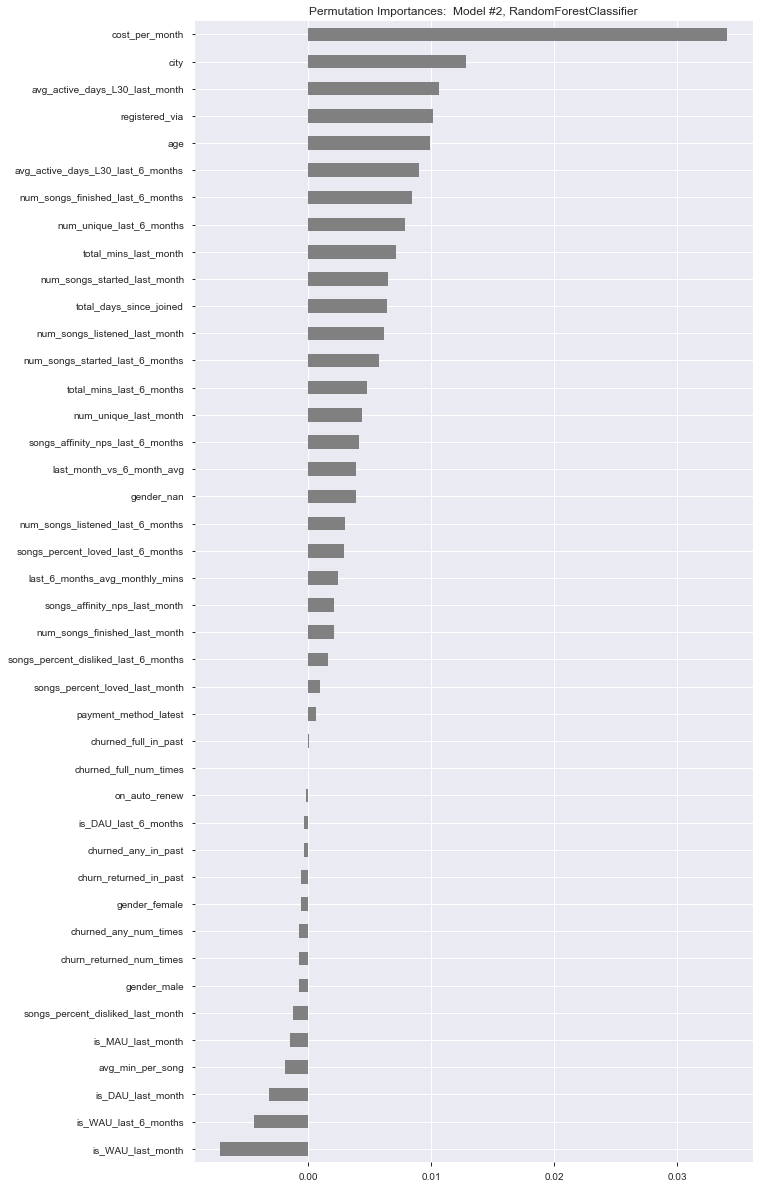

In [310]:
# Permutation importances:

# Initialize and fit the permuter:
import eli5
from eli5.sklearn import PermutationImportance

permuter_rf = PermutationImportance(
    m2_rf, 
    scoring='neg_log_loss',  # Other options: 'neg_log_loss', 'recall', 'accuracy', ROC AUC ??
    n_iter=5, 
    random_state=42
)

permuter_rf.fit(X_val_transformed, y_val)

# -----------------------------------------------------------------------------------------------------------

# Plot chart with the permutation importance values for each feature:
%matplotlib inline
import matplotlib.pyplot as plt

feature_names = X_val.columns.tolist()
perm_importances_rf = pd.Series(permuter_rf.feature_importances_, feature_names)

# Plot feature importances:
n = len(feature_names)
plt.figure(figsize=(10, n/2))
perm_importances_rf.sort_values(ascending=True).plot.barh(color='grey')
plt.title('Permutation Importances:  Model #2, RandomForestClassifier')
plt.show()

In [311]:
# Show heatmap w/ permutation importances' weights:
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter_rf, 
    top=None, 
    feature_names=feature_names
)

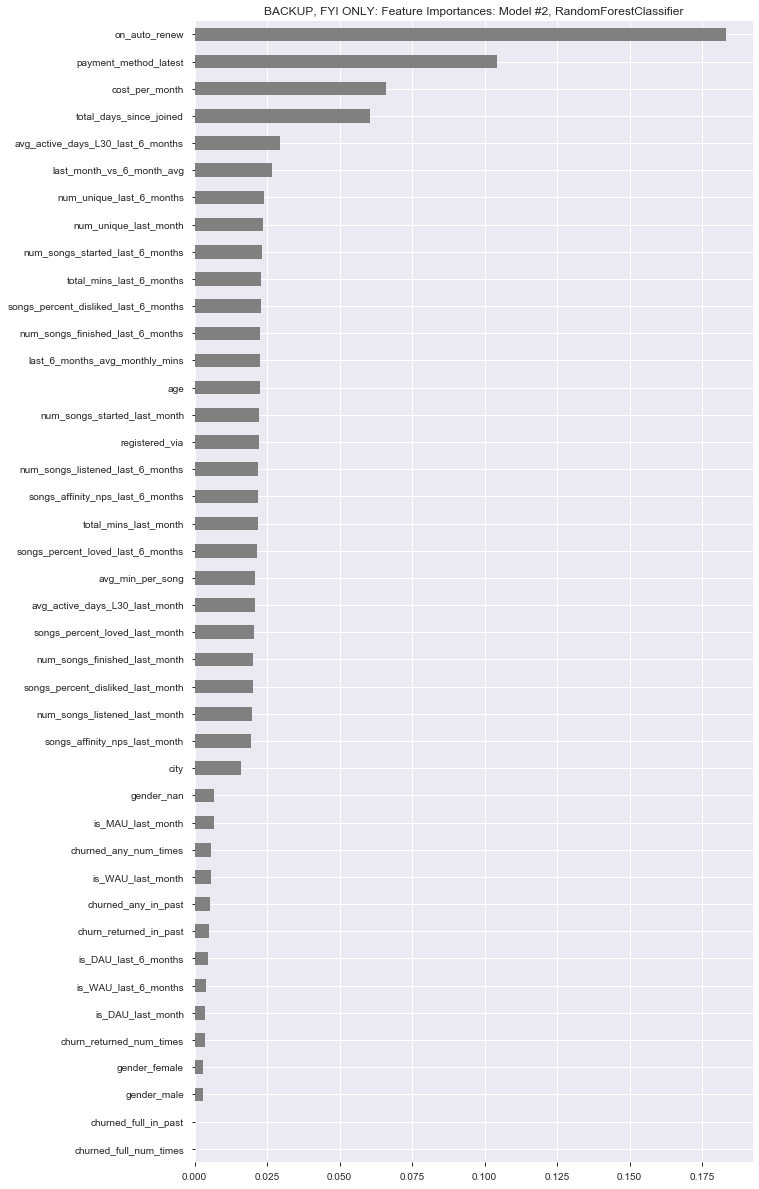

In [312]:
# BACKUP, FYI ONLY: Raw feature importances from model:

# Feature importances:
%matplotlib inline
import matplotlib.pyplot as plt

encoder = transformers.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_train).columns
feat_importances_rf = pd.Series(m2_rf.feature_importances_, encoded_columns)

# Plot feature importances:
n = len(encoded_columns)
plt.figure(figsize=(10, n/2))
feat_importances_rf.sort_values().plot.barh(color='grey')
plt.title('BACKUP, FYI ONLY: Feature Importances: Model #2, RandomForestClassifier')
plt.show()

### Model 3:  Gradient-boosted Trees (Ensemble)

In [313]:
from xgboost import XGBClassifier

# Separate transformers/pipeline from XGBClassifier model, so we can later use eli5 to get permutation importances:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

m3_gbt = XGBClassifier(n_estimators=50, max_depth=8, n_jobs=-1, random_state=42)
m3_gbt.fit(X_train_transformed, y_train)

# Performance on training data:
y_true_m3_train = y_train
y_pred_m3_train = m3_gbt.predict(X_train_transformed)

# Get TP, FN, FP, TN:
cm_m3_train = pd.DataFrame(confusion_matrix(y_true_m3_train, y_pred_m3_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m3_train.loc['actual_1', 'pred_1']
FN = cm_m3_train.loc['actual_1', 'pred_0']
FP = cm_m3_train.loc['actual_0', 'pred_1']
TN = cm_m3_train.loc['actual_0', 'pred_0']

print('\nModel #3: Gradient-boosted Trees Performance:\n')

# --------- TRAIN --------------------------------------------
print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m3_train, y_pred_m3_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m3_train, y_pred_m3_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m3_train_proba = m3_gbt.predict_proba(X_train_transformed)
print(f'Log loss (negative): {log_loss(y_true_m3_train, y_pred_m3_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_m3_train / cm_m3_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_m3_train / cm_m3_train.sum().sum()

# ---------- VAL ---------------------------------------------
# Apply to val and get score:
y_true_m3_val = y_val
y_pred_m3_val = m3_gbt.predict(X_val_transformed)

# Get TP, FN, FP, TN:
cm_m3_val = pd.DataFrame(confusion_matrix(y_true_m3_val, y_pred_m3_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m3_val.loc['actual_1', 'pred_1']
FN = cm_m3_val.loc['actual_1', 'pred_0']
FP = cm_m3_val.loc['actual_0', 'pred_1']
TN = cm_m3_val.loc['actual_0', 'pred_0']

print('\nVALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m3_val, y_pred_m3_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m3_val, y_pred_m3_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m3_val_proba = m3_gbt.predict_proba(X_val_transformed)
print(f'Log loss (negative): {log_loss(y_true_m3_val, y_pred_m3_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_m3_val / cm_m3_val.sum().sum()).sum().sum(), 10) == 1.0
cm_m3_val / cm_m3_val.sum().sum()


Model #3: Gradient-boosted Trees Performance:

TRAINING SET:

Accuracy: 0.833
Recall : 0.813
"Miss Rate" (FNR): 0.187
Log loss (negative): 0.372


VALIDATION SET:

Accuracy: 0.814
Recall : 0.760
"Miss Rate" (FNR): 0.240
Log loss (negative): 0.508

Confusion matrix, normalized:


pred_0    pred_1
actual_0  0.766584  0.170425
actual_1  0.015129  0.047862

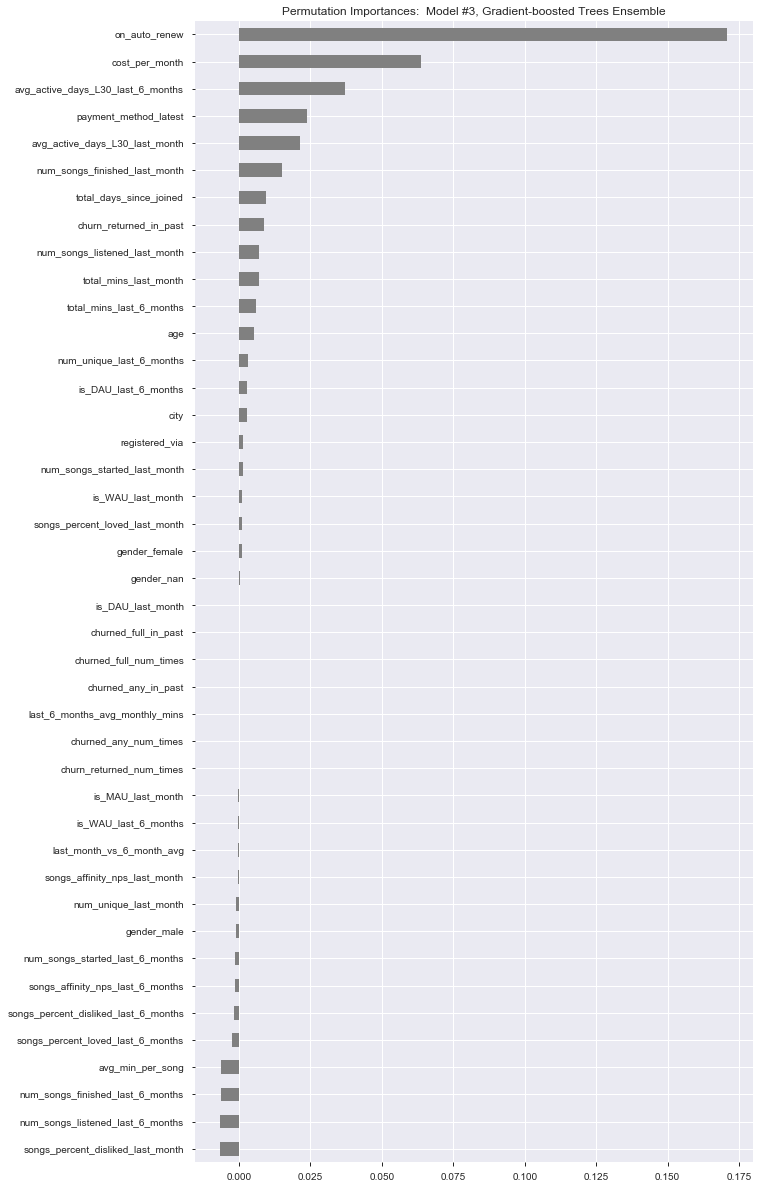

In [314]:
# Initialize and fit the permuter:
import eli5
from eli5.sklearn import PermutationImportance

permuter_gbt = PermutationImportance(
    m3_gbt, 
    scoring='neg_log_loss',  # OR 'neg_log_loss'
    n_iter=5, 
    random_state=42
)

permuter_gbt.fit(X_val_transformed, y_val)

# -----------------------------------------------------------------------------------------------------------

# Plot chart with the permutation importance values for each feature:
%matplotlib inline
import matplotlib.pyplot as plt

feature_names = X_val.columns.tolist()
perm_importances_gbt = pd.Series(permuter_gbt.feature_importances_, feature_names)

# Plot feature importances:
n = len(feature_names)
plt.figure(figsize=(10, n/2))
perm_importances_gbt.sort_values(ascending=True).plot.barh(color='grey')
plt.title('Permutation Importances:  Model #3, Gradient-boosted Trees Ensemble')
plt.show()

In [315]:
# Show heatmap w/ permutation importances' weights:
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter_gbt, 
    top=None, 
    feature_names=feature_names
)

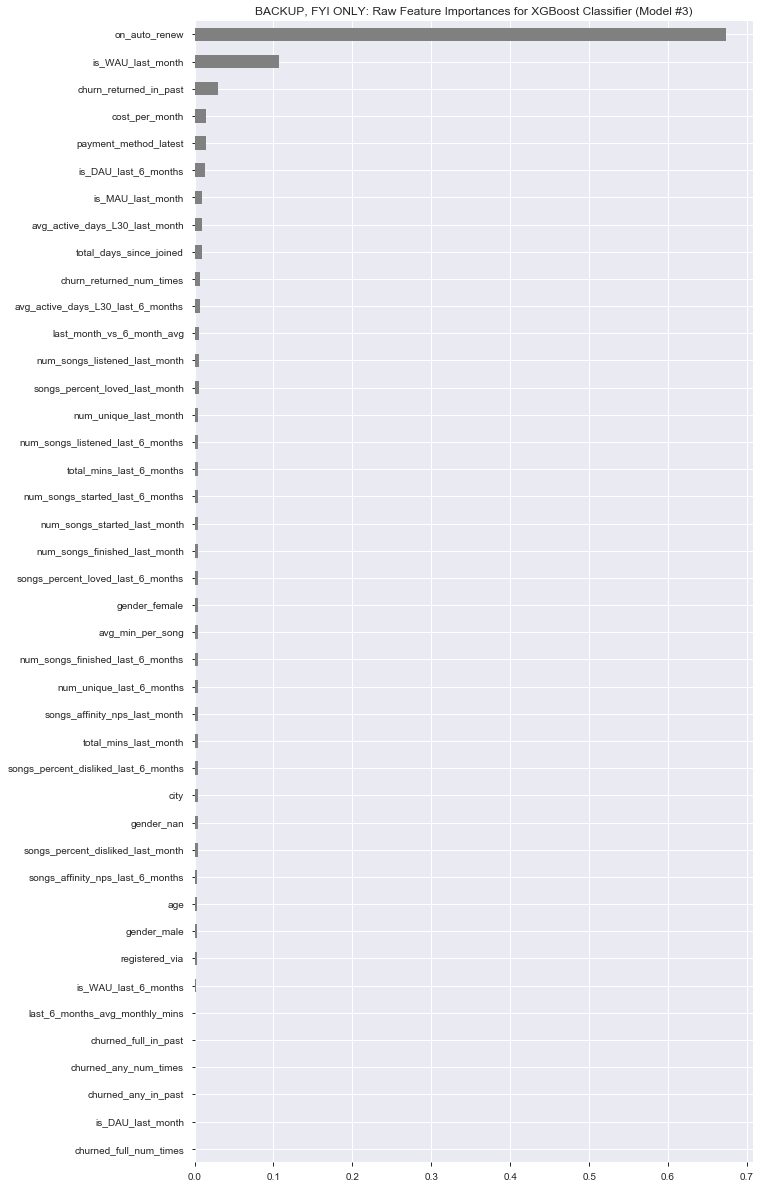

In [316]:
# BACKUP / FYI ONLY:

# Feature importances:
%matplotlib inline
import matplotlib.pyplot as plt

encoder = transformers.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
feat_importances_gbt = pd.Series(m3_gbt.feature_importances_, encoded_columns)

# Plot on chart, sorted from most to least important:
n = len(encoded_columns)
plt.figure(figsize=(10, n/2))
feat_importances_gbt.sort_values().plot.barh(color='grey')
plt.title('BACKUP, FYI ONLY: Raw Feature Importances for XGBoost Classifier (Model #3)')
plt.show()

### Hyperparameter optimization:

In [317]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Separate transformers/pipeline from XGBClassifier model, so we can later use eli5 to get permutation importances:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

m3_gbt = XGBClassifier(n_estimators=50, random_state=42)

scale_pos_weight = train[target].value_counts(normalize=True)[0] / train[target].value_counts(normalize=True)[1]

param_distributions_gbt = {
    'XGBClassifier__max_depth': sp_randint(3, 40), 
    'XGBClassifier__learning_rate': sp_uniform(0, 0.50), 
    'XGBClassifier__min_child_weight': sp_uniform(1, 8), 
    'XGBClassifier__scale_pos_weight': sp_uniform(scale_pos_weight * 0.5, scale_pos_weight * 1.5)
}

cv = StratifiedKFold(n_splits=3, random_state=42)

random_search_gbt = RandomizedSearchCV(
    m3_gbt, 
    param_distributions=param_distributions_gbt, 
    n_iter=30, 
    scoring='neg_log_loss',  # Best options: 'recall', 'neg_log_loss', 'accuracy', 'roc_auc', 
    # [?? To do: above for scoring=, try to (1) use 'neg_log_loss' (requires predict_proba), (2) use multiple scoring metrics together (there is a way: see line below), (3) see if worthwhile to custom define FNR (miss rate) too ??]
    # multi-metric evaluation, link 1: https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
    # multi-metric eval, link 2: https://scikit-learn.org/stable/modules/grid_search.html#multimetric-grid-search
    # Making a custom scoring method (maybe for FNR/miss rate)?:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer
    cv=cv, 
    verbose=True, 
    return_train_score=True, 
    n_jobs=-2, 
    pre_dispatch=2*3, 
    random_state=42
)

random_search_gbt.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-2)]: Done  90 out of  90 | elapsed:   53.9s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=50,
                                           n_jobs=1, nthread=None...
                                        'XGBClassifier__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1abcd5390>,
                                        'XGBClassifier__min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2185d6ba8>,
         

In [318]:
random_search_gbt.best_params_

{'XGBClassifier__learning_rate': 0.18727005942368125,
 'XGBClassifier__max_depth': 31,
 'XGBClassifier__min_child_weight': 2.4674783189293104,
 'XGBClassifier__scale_pos_weight': 1.3492320438698036}

In [319]:
25000 / train_all.shape[0]

0.03357065548719078

In [320]:
random_search_gbt.best_score_

-0.48135514391922835

In [321]:
random_search_gbt.best_estimator_

XGBClassifier(XGBClassifier__learning_rate=0.18727005942368125,
              XGBClassifier__max_depth=31,
              XGBClassifier__min_child_weight=2.4674783189293104,
              XGBClassifier__scale_pos_weight=1.3492320438698036,
              base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [322]:
pd.DataFrame(random_search_gbt.cv_results_).sort_values(by='mean_test_score').T

0   \
mean_fit_time                                                                    2.98061   
std_fit_time                                                                   0.0410358   
mean_score_time                                                                0.0278763   
std_score_time                                                                0.00413679   
param_XGBClassifier__learning_rate                                               0.18727   
param_XGBClassifier__max_depth                                                        31   
param_XGBClassifier__min_child_weight                                            2.46748   
param_XGBClassifier__scale_pos_weight                                            1.34923   
params                                 {'XGBClassifier__learning_rate': 0.18727005942...   
split0_test_score                                                               -0.48576   
split1_test_score                                                              -0.482935   
split2_test_score                                                               -0.47537   
mean_test_score                                                                -0.481355   
std_test_score                                                                 0.0043862   
rank_test_score                                                                        1   
split0_train_score                                                             -0.473625   
split1_train_score                                                             -0.474348   
split2_train_score                                                             -0.479185   
mean_train_score                                                               -0.475719   
std_train_score                                                               0.00246838   

                                                                                      27  \
mean_fit_time                                                                     3.1623   
std_fit_time                                                                   0.0762658   
mean_score_time                                                                0.0284307   
std_score_time                                                                0.00113771   
param_XGBClassifier__learning_rate                                              0.302209   
param_XGBClassifier__max_depth                                                        17   
param_XGBClassifier__min_child_weight                                            7.04441   
param_XGBClassifier__scale_pos_weight                                           0.681428   
params                                 {'XGBClassifier__learning_rate': 0.30220868963...   
split0_test_score                                                               -0.48576   
split1_test_score                                                              -0.482935   
split2_test_score                                                               -0.47537   
mean_test_score                                                                -0.481355   
std_test_score                                                                 0.0043862   
rank_test_score                                                                        1   
split0_train_score                                                             -0.473625   
split1_train_score                                                             -0.474348   
split2_train_score                                                             -0.479185   
mean_train_score                                                               -0.475719   
std_train_score                                                               0.00246838   

                                                                                      26  \
mean_fit_time                                                                    3.21655   
std_fit_time                        

In [323]:
print('\nModel #3(b) Performance: Gradient-boosted Trees w/ Best Hyperparameters:\n')

# --------- TRAIN --------------------------------------------
# Performance on training data:
y_true_m3_train = y_train
y_pred_m3_train = random_search_gbt.predict(X_train_transformed)

# Get TP, FN, FP, TN:
cm_m3_train = pd.DataFrame(confusion_matrix(y_true_m3_train, y_pred_m3_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m3_train.loc['actual_1', 'pred_1']
FN = cm_m3_train.loc['actual_1', 'pred_0']
FP = cm_m3_train.loc['actual_0', 'pred_1']
TN = cm_m3_train.loc['actual_0', 'pred_0']

print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m3_train, y_pred_m3_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m3_train, y_pred_m3_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m3_train_proba = random_search_gbt.predict_proba(X_train_transformed)
print(f'Log loss (negative): {log_loss(y_true_m3_train, y_pred_m3_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_m3_train / cm_m3_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_m3_train / cm_m3_train.sum().sum()

# ---------- VAL ---------------------------------------------
# Apply to val and get score:
y_true_m3_val = y_val
y_pred_m3_val = random_search_gbt.predict(X_val_transformed)

# Get TP, FN, FP, TN:
cm_m3_val = pd.DataFrame(confusion_matrix(y_true_m3_val, y_pred_m3_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m3_val.loc['actual_1', 'pred_1']
FN = cm_m3_val.loc['actual_1', 'pred_0']
FP = cm_m3_val.loc['actual_0', 'pred_1']
TN = cm_m3_val.loc['actual_0', 'pred_0']

print('\nVALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m3_val, y_pred_m3_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m3_val, y_pred_m3_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m3_val_proba = random_search_gbt.predict_proba(X_val_transformed)
print(f'Log loss (negative): {log_loss(y_true_m3_val, y_pred_m3_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_m3_val / cm_m3_val.sum().sum()).sum().sum(), 10) == 1.0
cm_m3_val / cm_m3_val.sum().sum()


Model #3(b) Performance: Gradient-boosted Trees w/ Best Hyperparameters:

TRAINING SET:

Accuracy: 0.775
Recall : 0.734
"Miss Rate" (FNR): 0.266
Log loss (negative): 0.478


VALIDATION SET:

Accuracy: 0.816
Recall : 0.746
"Miss Rate" (FNR): 0.254
Log loss (negative): 0.537

Confusion matrix, normalized:


pred_0    pred_1
actual_0  0.769494  0.167515
actual_1  0.016002  0.046989

### Early stopping (for n_estimators):

In [324]:
# Best params to input:
max_depth_best = random_search_gbt.best_params_['XGBClassifier__max_depth']
learning_rate_best = random_search_gbt.best_params_['XGBClassifier__learning_rate']
min_child_weight_best = random_search_gbt.best_params_['XGBClassifier__min_child_weight']

In [325]:
random_search_gbt.best_estimator_

XGBClassifier(XGBClassifier__learning_rate=0.18727005942368125,
              XGBClassifier__max_depth=31,
              XGBClassifier__min_child_weight=2.4674783189293104,
              XGBClassifier__scale_pos_weight=1.3492320438698036,
              base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [326]:
from xgboost import XGBClassifier

# Separate transformers/pipeline from XGBClassifier model, so we can later use eli5 to get permutation importances:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

m3_gbt_tuned = XGBClassifier(n_estimators=1000, 
                             max_depth=max_depth_best, 
                             learning_rate=learning_rate_best, 
                             min_child_weight=min_child_weight_best, 
                             n_jobs=-2, 
                             random_state=42)

eval_set = [(X_train_transformed, y_train), 
           (X_val_transformed, y_val)]

m3_gbt_tuned.fit(X_train_transformed, 
           y_train, 
           eval_set=eval_set, 
           eval_metric='logloss',  # Options: logloss, (no recall...), auc (https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters)
           verbose=True, 
           early_stopping_rounds=50)

# Performance on training data:
y_true_m3_train = y_train
y_pred_m3_train = m3_gbt_tuned.predict(X_train_transformed)

# Get TP, FN, FP, TN:
cm_m3_train = pd.DataFrame(confusion_matrix(y_true_m3_train, y_pred_m3_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m3_train.loc['actual_1', 'pred_1']
FN = cm_m3_train.loc['actual_1', 'pred_0']
FP = cm_m3_train.loc['actual_0', 'pred_1']
TN = cm_m3_train.loc['actual_0', 'pred_0']

print('\nModel #3: Gradient-boosted Trees Performance:\n')

# --------- TRAIN --------------------------------------------
print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m3_train, y_pred_m3_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m3_train, y_pred_m3_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m3_train_proba = m3_gbt_tuned.predict_proba(X_train_transformed)
print(f'Log loss (negative): {log_loss(y_true_m3_train, y_pred_m3_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_m3_train / cm_m3_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_m3_train / cm_m3_train.sum().sum()

# ---------- VAL ---------------------------------------------

# Apply to val and get score:
y_true_m3_val = y_val
y_pred_m3_val = m3_gbt_tuned.predict(X_val_transformed)

# Get TP, FN, FP, TN:
cm_m3_val = pd.DataFrame(confusion_matrix(y_true_m3_val, y_pred_m3_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m3_val.loc['actual_1', 'pred_1']
FN = cm_m3_val.loc['actual_1', 'pred_0']
FP = cm_m3_val.loc['actual_0', 'pred_1']
TN = cm_m3_val.loc['actual_0', 'pred_0']

print('\nVALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m3_val, y_pred_m3_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m3_val, y_pred_m3_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m3_val_proba = m3_gbt_tuned.predict_proba(X_val_transformed)
print(f'Log loss (negative): {log_loss(y_true_m3_val, y_pred_m3_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_m3_val / cm_m3_val.sum().sum()).sum().sum(), 10) == 1.0
cm_m3_val / cm_m3_val.sum().sum()

[0]	validation_0-logloss:0.601017	validation_1-logloss:0.633224
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.532874	validation_1-logloss:0.592107
[2]	validation_0-logloss:0.479622	validation_1-logloss:0.56222
[3]	validation_0-logloss:0.437112	validation_1-logloss:0.539905
[4]	validation_0-logloss:0.401739	validation_1-logloss:0.523723
[5]	validation_0-logloss:0.37287	validation_1-logloss:0.511702
[6]	validation_0-logloss:0.347363	validation_1-logloss:0.502512
[7]	validation_0-logloss:0.325787	validation_1-logloss:0.495813
[8]	validation_0-logloss:0.306826	validation_1-logloss:0.490078
[9]	validation_0-logloss:0.290355	validation_1-logloss:0.486258
[10]	validation_0-logloss:0.275686	validation_1-logloss:0.482374
[11]	validation_0-logloss:0.262754	validation_1-logloss:0.480654
[12]	validation_0-logloss:0.251372	validation_1-logloss:0.479754
[1

pred_0    pred_1
actual_0  0.761020  0.175989
actual_1  0.016184  0.046807

In [327]:
m3_gbt_tuned.best_score

0.47848

In [328]:
m3_gbt_tuned

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.18727005942368125, max_delta_step=0, max_depth=31,
              min_child_weight=2.4674783189293104, missing=None,
              n_estimators=1000, n_jobs=-2, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [329]:
m3_gbt_tuned.best_iteration

13

In [330]:
m3_gbt_tuned.best_ntree_limit

14

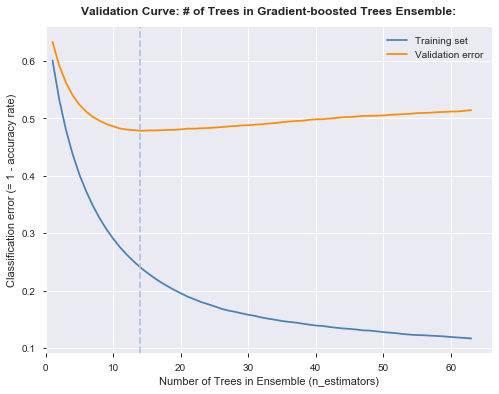

In [331]:
# Validation curve of early stopping results from above:
early_stopping_results = m3_gbt_tuned.evals_result()
train_error = early_stopping_results['validation_0']['logloss']
val_error = early_stopping_results['validation_1']['logloss']

best_num_estimators = m3_gbt_tuned.best_ntree_limit

# Plot these results as a validation curve:

# x-values: Epoch #:
epoch_num = list(range(1, len(train_error) + 1))

# Plot train and val errors:

plt.figure(figsize=(8, 6))
plt.style.context('seaborn-notebook')
plt.plot(epoch_num, train_error, label='Training set', color='steelblue')
plt.plot(epoch_num, val_error, label='Validation error', color='darkorange')

plt.title('Validation Curve: # of Trees in Gradient-boosted Trees Ensemble:', 
          y=1.02, 
          fontsize=12, 
          fontweight='bold')
plt.xlabel('Number of Trees in Ensemble (n_estimators)')
plt.ylabel('Classification error (= 1 - accuracy rate)')
plt.legend()

ax = plt.gca()
# ax.set(facecolor='white')
# ax.grid(True, color='whitesmoke')
ax.set_xlim(0)

# Show or hide borders:
for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_visible(True)

# Line showing selected best number of trees (n_estimators) to use:
ax.axvline(x=best_num_estimators, linestyle='--', color='lightsteelblue')

plt.show()

# Final Model:

In [332]:
# Best params to input:
assert max_depth_best == random_search_gbt.best_params_['XGBClassifier__max_depth']
assert learning_rate_best == random_search_gbt.best_params_['XGBClassifier__learning_rate']
assert min_child_weight_best == random_search_gbt.best_params_['XGBClassifier__min_child_weight']
assert best_num_estimators == m3_gbt_tuned.best_ntree_limit

In [333]:
from xgboost import XGBClassifier

# Separate transformers/pipeline from XGBClassifier model, so we can later use eli5 to get permutation importances:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean')  # Impute NaNs for permuter (next cell), even though not needed for XGBClassifier
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

mfinal = XGBClassifier(n_estimators=best_num_estimators, 
                       max_depth=max_depth_best, 
                       learning_rate=learning_rate_best, 
                       min_child_weight=min_child_weight_best, 
                       n_jobs=-2, 
                       random_state=42)

# mfinal = m3_gbt_tuned

mfinal.fit(X_train_transformed, y_train)

# Performance on training data:
y_true_mfinal_train = y_train
y_pred_mfinal_train = mfinal.predict(X_train_transformed)

# Get TP, FN, FP, TN:
cm_mfinal_train = pd.DataFrame(confusion_matrix(y_true_mfinal_train, y_pred_mfinal_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_mfinal_train.loc['actual_1', 'pred_1']
FN = cm_mfinal_train.loc['actual_1', 'pred_0']
FP = cm_mfinal_train.loc['actual_0', 'pred_1']
TN = cm_mfinal_train.loc['actual_0', 'pred_0']

print('\nFinal Model: Gradient-boosted Trees w/ Optimized Hyperparameters:\n')

# --------- TRAIN --------------------------------------------
print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_mfinal_train, y_pred_mfinal_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_mfinal_train, y_pred_mfinal_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_mfinal_train_proba = mfinal.predict_proba(X_train_transformed)
print(f'Log loss (negative): {log_loss(y_true_mfinal_train, y_pred_mfinal_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_mfinal_train / cm_mfinal_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_mfinal_train / cm_mfinal_train.sum().sum()

# ---------- VAL ---------------------------------------------
# Apply to val and get score:
y_true_mfinal_val = y_val
y_pred_mfinal_val = mfinal.predict(X_val_transformed)

# Get TP, FN, FP, TN:
cm_mfinal_val = pd.DataFrame(confusion_matrix(y_true_mfinal_val, y_pred_mfinal_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_mfinal_val.loc['actual_1', 'pred_1']
FN = cm_mfinal_val.loc['actual_1', 'pred_0']
FP = cm_mfinal_val.loc['actual_0', 'pred_1']
TN = cm_mfinal_val.loc['actual_0', 'pred_0']

print('\nVALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_mfinal_val, y_pred_mfinal_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_mfinal_val, y_pred_mfinal_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_mfinal_val_proba = mfinal.predict_proba(X_val_transformed)
print(f'Log loss (negative): {log_loss(y_true_mfinal_val, y_pred_mfinal_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_mfinal_val / cm_mfinal_val.sum().sum()).sum().sum(), 10) == 1.0
cm_mfinal_val / cm_mfinal_val.sum().sum()

# [?? To do:  Add in cross-validation avg. score using cross_val_score ??]
# print('CROSS-VALIDATED AVG. ACROSS MULTIPLE TRAIN/VAL SPLITS:')
# [?? To do:  Add in cross-validation avg. score using cross_val_score ??]


Final Model: Gradient-boosted Trees w/ Optimized Hyperparameters:

TRAINING SET:

Accuracy: 0.931
Recall : 0.928
"Miss Rate" (FNR): 0.072
Log loss (negative): 0.241


VALIDATION SET:

Accuracy: 0.808
Recall : 0.743
"Miss Rate" (FNR): 0.257
Log loss (negative): 0.478

Confusion matrix, normalized:


pred_0    pred_1
actual_0  0.761020  0.175989
actual_1  0.016184  0.046807

In [334]:
mfinal

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.18727005942368125, max_delta_step=0, max_depth=31,
              min_child_weight=2.4674783189293104, missing=None,
              n_estimators=14, n_jobs=-2, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

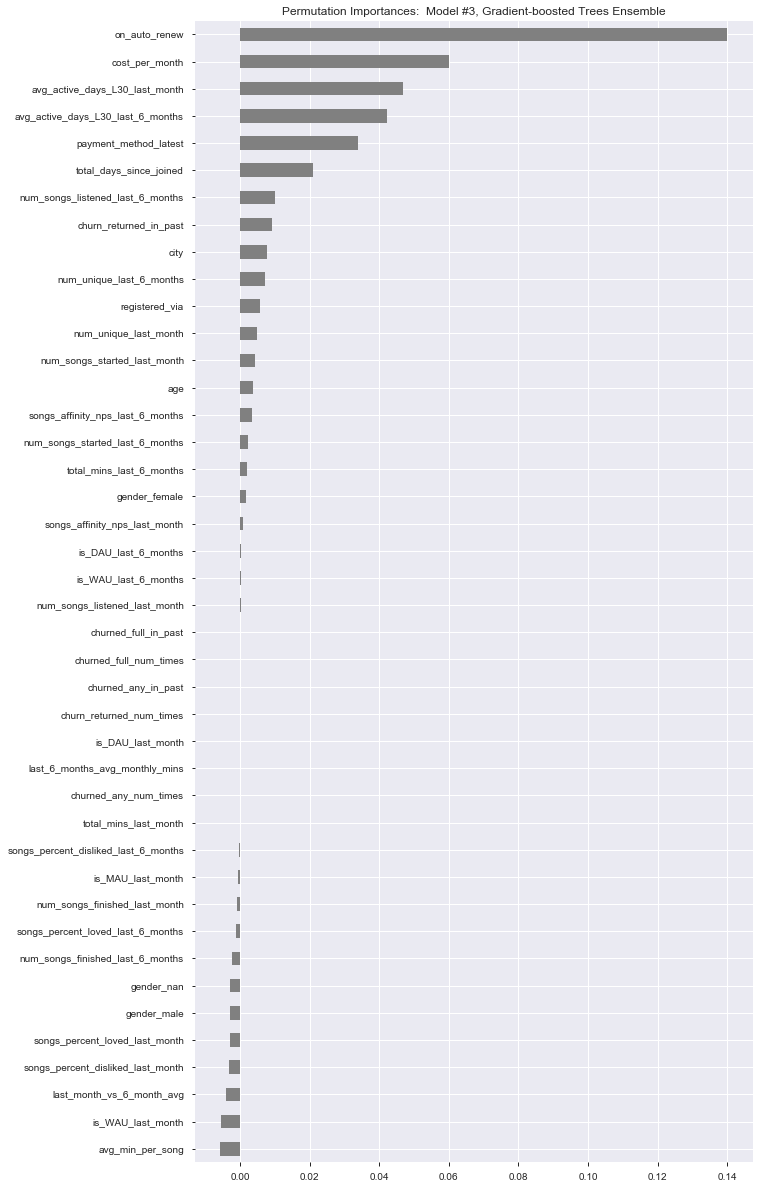

In [335]:
# Initialize and fit the permuter:
import eli5
from eli5.sklearn import PermutationImportance

permuter_mfinal = PermutationImportance(
    mfinal, 
    scoring='neg_log_loss',  # [?? To do: Change scoring in all permuters to -- what, negative log loss ??]
    n_iter=10, 
    random_state=42
)

permuter_mfinal.fit(X_val_transformed, y_val)

# -----------------------------------------------------------------------------------------------------------

# Plot chart with the permutation importance values for each feature:
%matplotlib inline
import matplotlib.pyplot as plt

feature_names = X_val.columns.tolist()
perm_importances_mfinal = pd.Series(permuter_mfinal.feature_importances_, feature_names)

# Plot feature importances:
n = len(feature_names)
plt.figure(figsize=(10, n/2))
perm_importances_mfinal.sort_values(ascending=True).plot.barh(color='grey')
plt.title('Permutation Importances:  Model #3, Gradient-boosted Trees Ensemble')
plt.show()

In [336]:
# Show heatmap w/ permutation importances' weights:
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter_mfinal, 
    top=None, 
    feature_names=feature_names
)

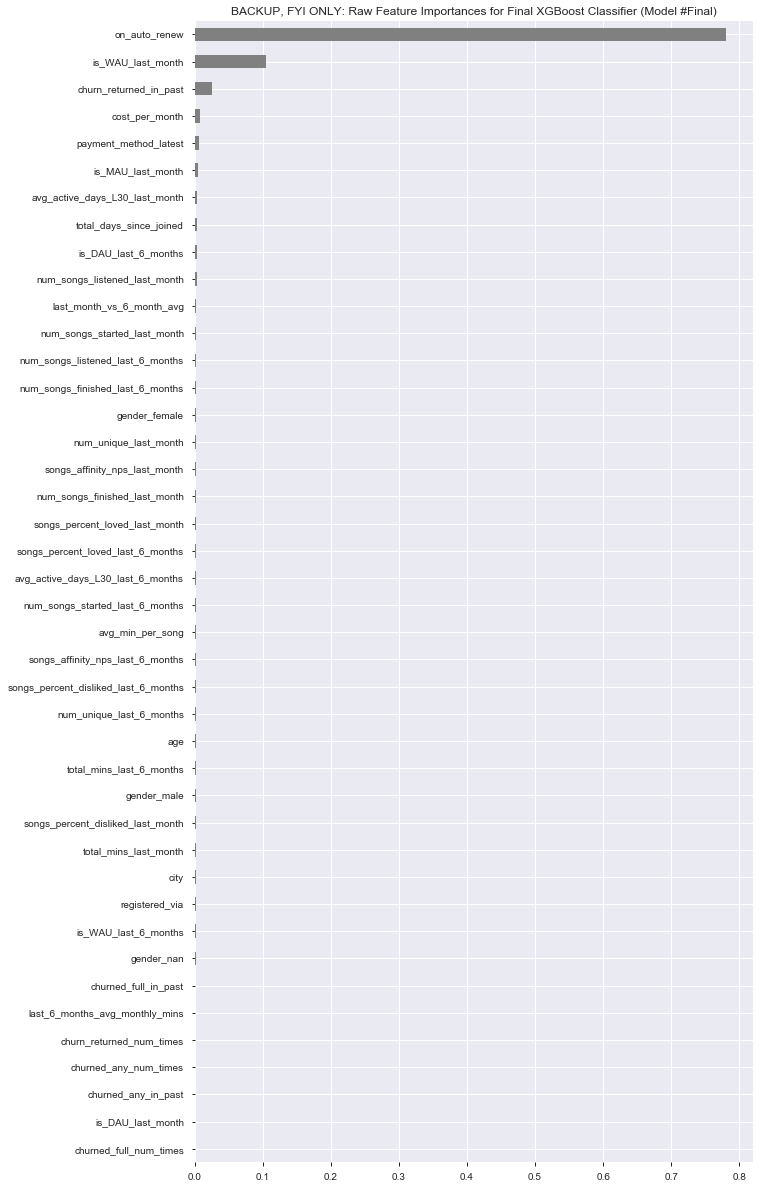

In [337]:
# BACKUP / FYI ONLY:

# Feature importances:
%matplotlib inline
import matplotlib.pyplot as plt

encoder = transformers.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
feat_importances_mfinal = pd.Series(mfinal.feature_importances_, encoded_columns)

# Plot on chart, sorted from most to least important:
n = len(encoded_columns)
plt.figure(figsize=(10, n/2))
feat_importances_mfinal.sort_values().plot.barh(color='grey')
plt.title('BACKUP, FYI ONLY: Raw Feature Importances for Final XGBoost Classifier (Model #Final)')
plt.show()

In [338]:
# To do:  Try setting (class_weight='balanced') in the estimator (e.g., LogisticRegressionCV) and/or consider different 
# class weights, to see if that would result in better predictive models (considering class imbalance in training data).

In [339]:
# Type of problem:  Classification + Regression Predicted Probability
# e.g., Churn:  “Which 5% of my customers will leave my business for a 
# competitor in the next year?” can be rephrased as “How likely is each 
# of my customers to leave my business for a competitor in the next year?”

# Core metric:  
# (1) Recall: maximize
# --> Our model's improvement in recall, as quantified in NT (and equivalent $$) amount!

# (2) False Negative Rate (FNR): minimize:

# [?? To do: also try out scoring with AUC, accuracy to cross check -- even though less important for this problem ??]

In [340]:
# e.g., Churn:  “Which 5% of my customers will leave my business for a competitor in the next year?” 
# can be rephrased as “How likely is each of my customers to leave my business for a competitor in the next year?”